In [5]:
from platform import python_version

print(python_version())

3.9.13


In [6]:
import sys 
print(sys.executable)

/Users/asus2/opt/anaconda3/bin/python


In [7]:
conda install -c conda-forge lightgbm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [8]:
#! pip install hyperopt

In [9]:
conda install -c conda-forge hyperopt

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [10]:
conda install -c conda-forge imbalanced-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [11]:
conda install -c conda-forge scikit-plot

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
conda install -c conda-forge shap

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install --upgrade shap


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [14]:
#conda list

In [15]:
# Load packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [16]:
#!yes | conda install -c conda-forge lightgbm


In [17]:
#!pip freeze

In [18]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [19]:
import gc
import time, pickle
import lightgbm as lgb
import hyperopt
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score, f1_score, precision_score, recall_score 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter
from imblearn.over_sampling import ADASYN 
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import  make_scorer

import scikitplot as skplt

from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import shap

In [20]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

### <b> Fonctions utiles: <b>

In [22]:
%run -i project_functions.ipynb

In [23]:
#!ls

In [24]:
import sys
print(sys.path)

['/Users/asus2/PROJET7', '/Users/asus2/opt/anaconda3/lib/python39.zip', '/Users/asus2/opt/anaconda3/lib/python3.9', '/Users/asus2/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/asus2/opt/anaconda3/lib/python3.9/site-packages', '/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/Users/asus2/.ipython']


## <b> Lecture des données :<b> 

First, we can list all the available data files. There are a total of 8 files: 1 main file for training (with target) 1 main file for testing (without the target), and 6 other files containing additional information about each loan.

In [27]:
# DATA READING

app_train = pd.read_csv('DONNEES/application_train.csv')
app_test = pd.read_csv('DONNEES/application_test.csv')


In [28]:

bureau = pd.read_csv("DONNEES/bureau.csv")
bureau_balance = pd.read_csv("DONNEES/bureau_balance.csv")
prev_app = pd.read_csv('DONNEES/previous_application.csv')
cash_balance = pd.read_csv("DONNEES/POS_CASH_balance.csv")
card_balance = pd.read_csv('DONNEES/credit_card_balance.csv')
payments = pd.read_csv('DONNEES/installments_payments.csv')


In [35]:
# Training data

print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [36]:
app_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

In [37]:
app_train_num=app_train.select_dtypes('number')
app_train_num.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   
2      100004       0             0           67500.0    135000.0   
3      100006       0             0          135000.0    312682.5   
4      100007       0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0           -637            -3648.0            -2120          NaN           1   
1          -1188            -1186.0             -291          NaN           1   
2           -225            -4260.0            -2531         26.0           1   
3          -3039            -9833.0            -2437          NaN           1   
4          -3038            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

In [38]:
app_train_num.shape

(307511, 106)

In [39]:
df_revenus = app_train[app_train["AMT_INCOME_TOTAL"] < 500000]
df_revenus.shape

(304809, 122)

In [40]:
app_train["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [41]:
print('Test data shape: ', app_test.shape)
app_test.head()


Test data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [42]:
app_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

In [43]:
#Check if 'TARGET' is the only different column between app_train and app_test
print(" columns wich are differents in app_train and app_test.")
display(app_train.columns.difference(app_test.columns))

 columns wich are differents in app_train and app_test.


Index(['TARGET'], dtype='object')

## <b> Stucture de données :<b>

In [44]:
describe_dataset({'Application Train': app_train,
                     'Application Test': app_test, 
                     'Bureau': bureau,
                     'Bureau Balance': bureau_balance,
                     'Credit Card Balance' : card_balance,
                     'Installments Payments': payments,
                     'POS CASH balance': cash_balance,
                     'Previous Application': prev_app})

Les données se décomposent en 8 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes   %NaN  %Duplicate
1      Application Train        307511             122  24.40         0.0
2       Application Test         48744             121  23.81         0.0
3                 Bureau       1716428              17  13.50         0.0
4         Bureau Balance      27299925               3   0.00         0.0
5    Credit Card Balance       3840312              23   6.65         0.0
6  Installments Payments      13605401               8   0.01         0.0
7       POS CASH balance      10001358               8   0.07         0.0
8   Previous Application       1670214              37  17.98         0.0

### <b> Description des datasets :<b>

In [45]:
print("DESCRIPTION :")
pd.set_option("max_colwidth", 300)
description = pd.read_csv('DONNEES/HomeCredit_columns_description.csv',  encoding="ISO-8859-1", index_col=0)
description

DESCRIPTION :


Table                           Row  \
1    application_{train|test}.csv                    SK_ID_CURR   
2    application_{train|test}.csv                        TARGET   
5    application_{train|test}.csv            NAME_CONTRACT_TYPE   
6    application_{train|test}.csv                   CODE_GENDER   
7    application_{train|test}.csv                  FLAG_OWN_CAR   
8    application_{train|test}.csv               FLAG_OWN_REALTY   
9    application_{train|test}.csv                  CNT_CHILDREN   
10   application_{train|test}.csv              AMT_INCOME_TOTAL   
11   application_{train|test}.csv                    AMT_CREDIT   
12   application_{train|test}.csv                   AMT_ANNUITY   
13   application_{train|test}.csv               AMT_GOODS_PRICE   
14   application_{train|test}.csv               NAME_TYPE_SUITE   
15   application_{train|test}.csv              NAME_INCOME_TYPE   
16   application_{train|test}.csv           NAME_EDUCATION_TYPE   
17   application_{train|test}.csv            NAME_FAMILY_STATUS   
18   application_{train|test}.csv             NAME_HOUSING_TYPE   
19   application_{train|test}.csv    REGION_POPULATION_RELATIVE   
20   application_{train|test}.csv                    DAYS_BIRTH   
21   application_{train|test}.csv                 DAYS_EMPLOYED   
22   application_{train|test}.csv             DAYS_REGISTRATION   
23   application_{train|test}.csv               DAYS_ID_PUBLISH   
24   application_{train|test}.csv                   OWN_CAR_AGE   
25   application_{train|test}.csv                    FLAG_MOBIL   
26   application_{train|test}.csv                FLAG_EMP_PHONE   
27   application_{train|test}.csv               FLAG_WORK_PHONE   
28   application_{train|test}.csv              FLAG_CONT_MOBILE   
29   application_{train|test}.csv                    FLAG_PHONE   
30   application_{train|test}.csv                    FLAG_EMAIL   
31   application_{train|test}.csv               OCCUPATION_TYPE   
32   application_{train|test}.csv               CNT_FAM_MEMBERS   
33   application_{train|test}.csv          REGION_RATING_CLIENT   
34   application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
35   application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
36   application_{train|test}.csv       HOUR_APPR_PROCESS_START   
37   application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
38   application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
39   application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
40   application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
41   application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
42   application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
43   application_{train|test}.csv             ORGANIZATION_TYPE   
44   application_{train|test}.csv                  EXT_SOURCE_1   
45   application_{train|test}.csv                  EXT_SOURCE_2   
46   application_{train|test}.csv                  EXT_SOURCE_3   
47   application_{train|test}.csv                APARTMENTS_AVG   
48   application_{train|test}.csv              BASEMENTAREA_AVG   
49   application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
50   application_{train|test}.csv               YEARS_BUILD_AVG   
51   application_{train|test}.csv                COMMONAREA_AVG   
52   application_{train|test}.csv                 ELEVATORS_AVG   
53   application_{train|test}.csv                 ENTRANCES_AVG   
54   application_{train|test}.csv                 FLOORSMAX_AVG   
55   application_{train|test}.csv                 FLOORSMIN_AVG   
56   application_{train|test}.csv                  LANDAREA_AVG   
57   application_{train|test}.csv          LIVINGAPARTMENTS_AVG   
58   application_{train|test}.csv                LIVINGAREA_AVG   
59   application_{train|test}.csv       NONLIVINGAPARTMENTS_AVG   
60   application_{train|test}.csv             NONLIVINGAREA_AVG   
61   application_{train|test}.csv               APARTMENTS_MODE   
62   app

In [46]:
description.shape

(219, 4)

# <b> Exploratory Data Analysis : <b>

Cette partie est inspirée du kernel kaggle suivant:   https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

### <b> Distribution of the Target Column<b>

In [47]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [48]:
#app_train['TARGET'].astype(int).plot.hist()

In [49]:
Imbalance = app_train["TARGET"].value_counts().reset_index()

Imbalance.head()

index  TARGET
0      0  282686
1      1   24825

In [52]:

def graph_col_category(dataframe, col, size, name):
    """This function represents the categorical variables as a pie plot.
    dataframe : dataset
    size : size of the figure (X,X)"""
    values = dataframe[col].value_counts()
    labels = dataframe[col].value_counts().index
    plt.figure(figsize=size)
  
    # Pie Plot
    plt.subplot(2, 2, 2)
    plt.title("Representation of the variable {}" .format(col), fontsize=10)
    plt.pie(values, labels=name, autopct='%.1f%%', shadow=True, textprops={'fontsize': 10})
    plt.axis('equal')
    plt.tight_layout()
    plt.legend()
    plt.show()


In [53]:
graph_col_category(app_train, 'TARGET', (9,9), ['Reimbursed', 'defaulted'])

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### <b>Missing values :<b>

In [55]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [56]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as LGBM classifier that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

### <b>Column Types : <b>

In [57]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [58]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. 

### <b> Aligning Training and Testing Data :<b>

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

In [59]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


### <b> Back to Exploratory Data Analysis :<b>

### <b>Anomalies :<b>

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [60]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [61]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

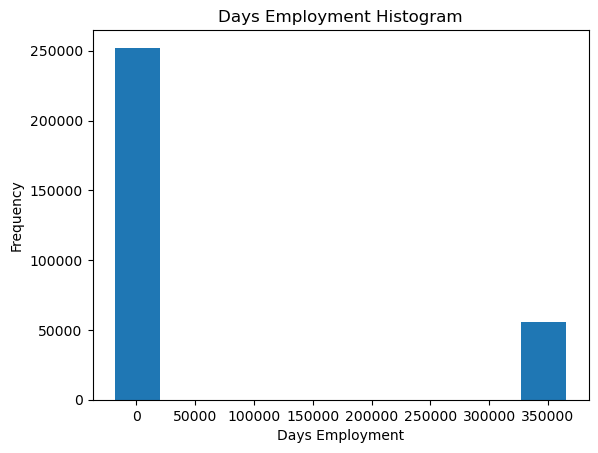

In [62]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [63]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

In [64]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

### <b> Correlations:<b>

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

- 0.00-0.19 “very weak”
-0.20-0.39 “weak”
-0.40-.59 “moderate”
-0.60-0.79 “strong”
-0.80-1.0 “very strong”

In [65]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


### <b> Effect of Age on Repayment: <b>

In [66]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982737

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

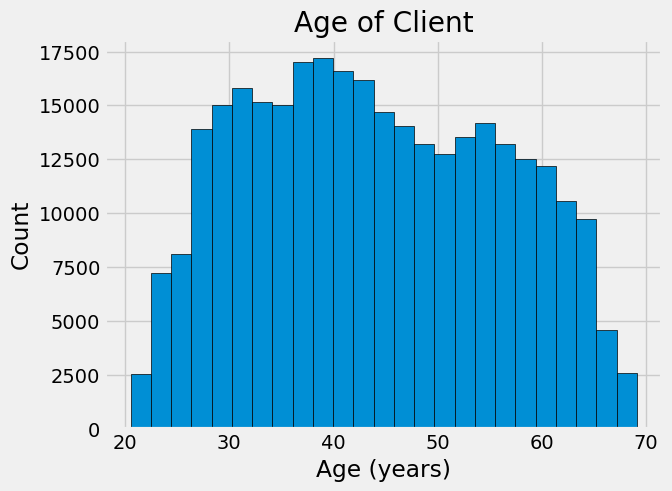

In [67]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

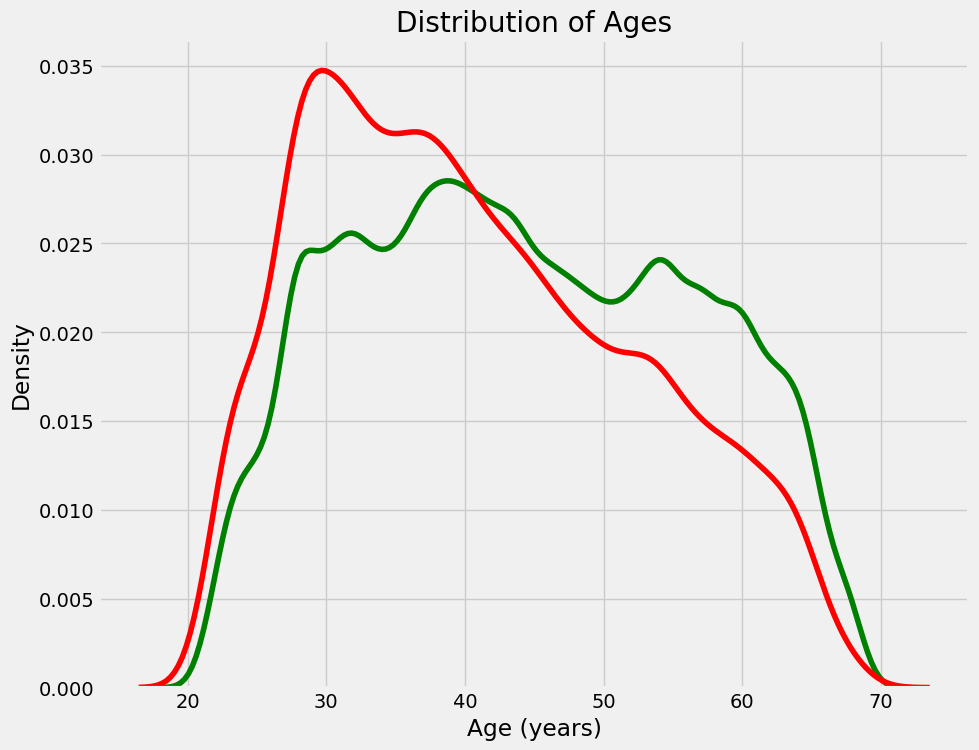

In [68]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, color = "Green", label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, color = "Red",label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [69]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [70]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

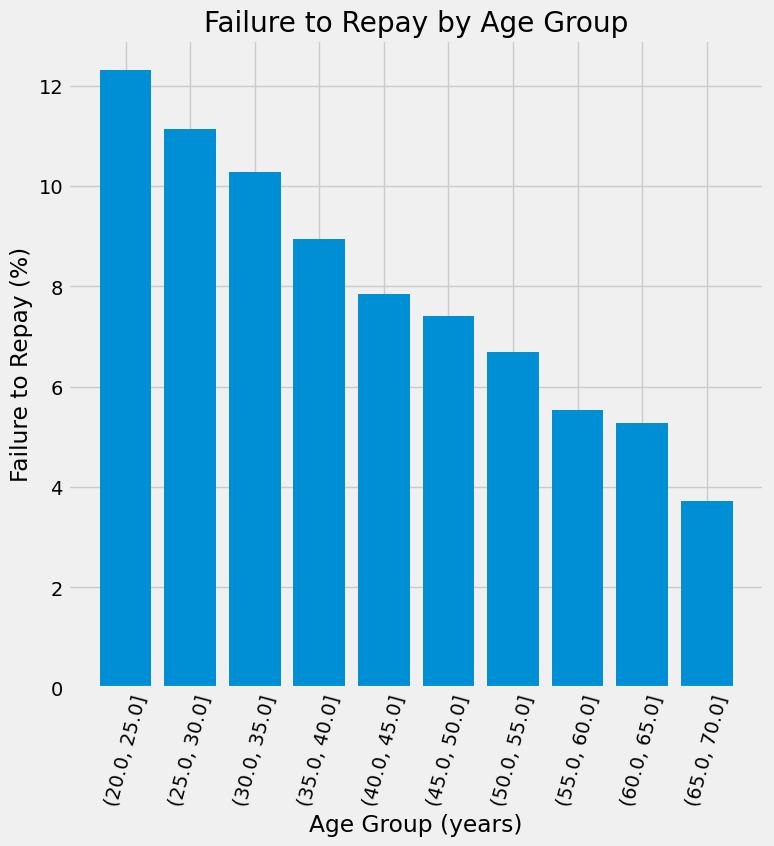

In [71]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

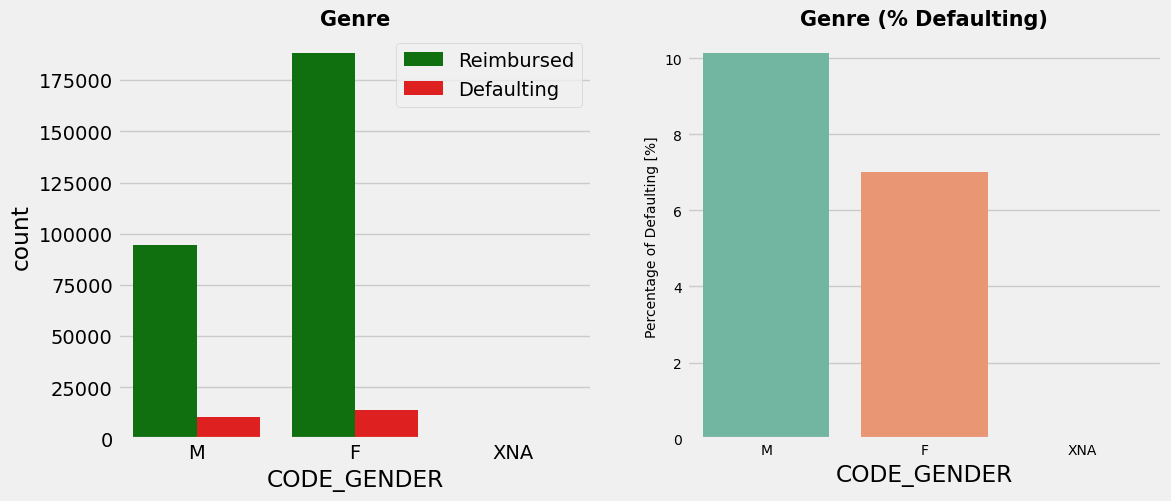

In [72]:
# Distribution du genre en fonction 
# de l'état de remboursement du prêt

univariate_categorical(app_train, 'CODE_GENDER', "Genre")

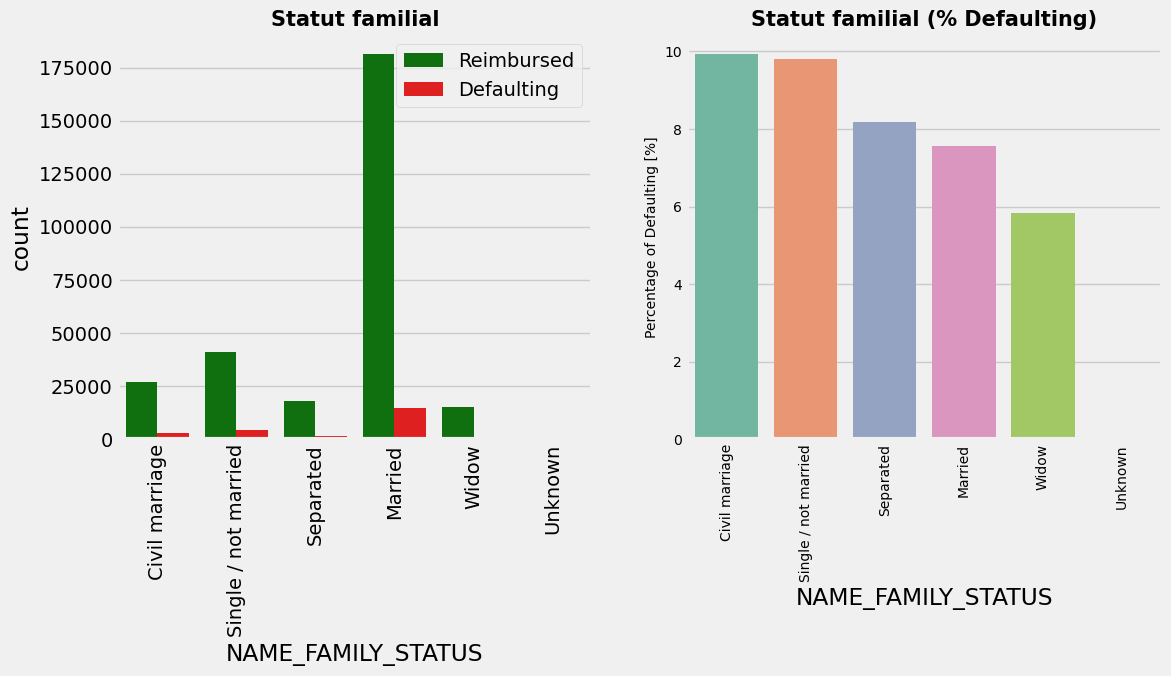

In [73]:
# Analyse de l'impact du statut familial
# sur de l'état de remboursement du prêt

univariate_categorical(app_train, 'NAME_FAMILY_STATUS', "Statut familial", False,True,True)

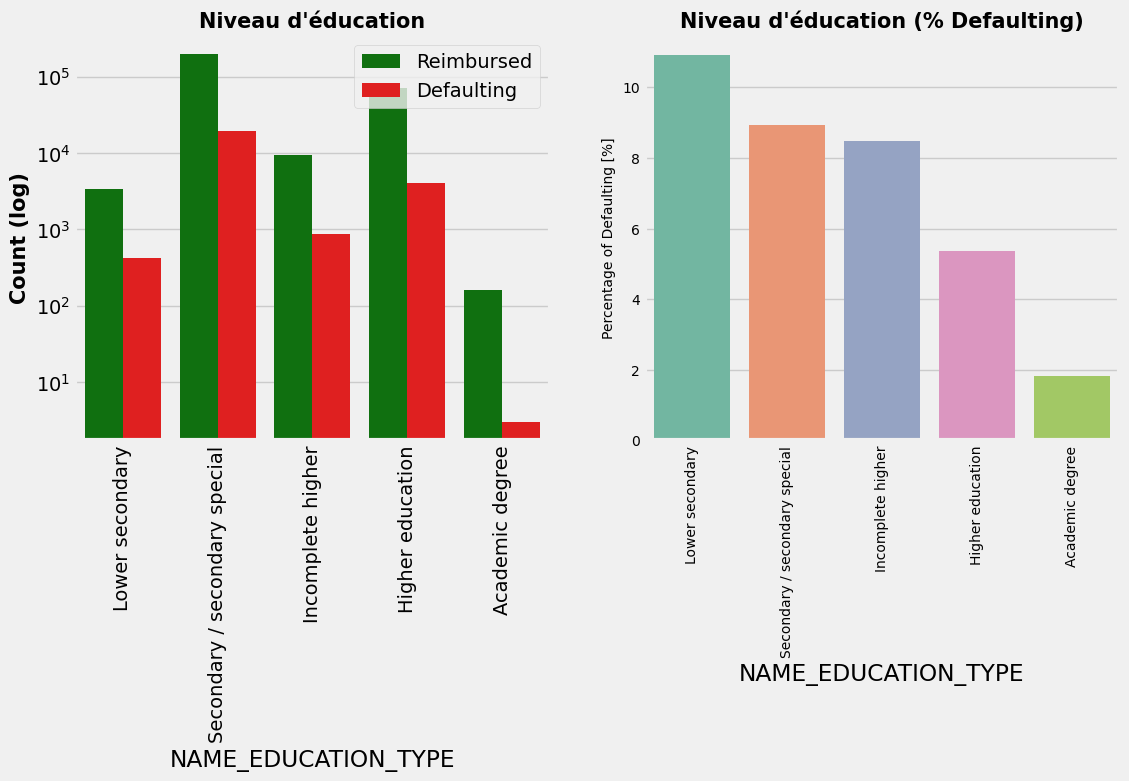

In [74]:
# Analyse de l'impact du niveau d'éducation
# sur de l'état de remboursement du prêt

univariate_categorical(app_train, 'NAME_EDUCATION_TYPE', "Niveau d'éducation", True,True,True)

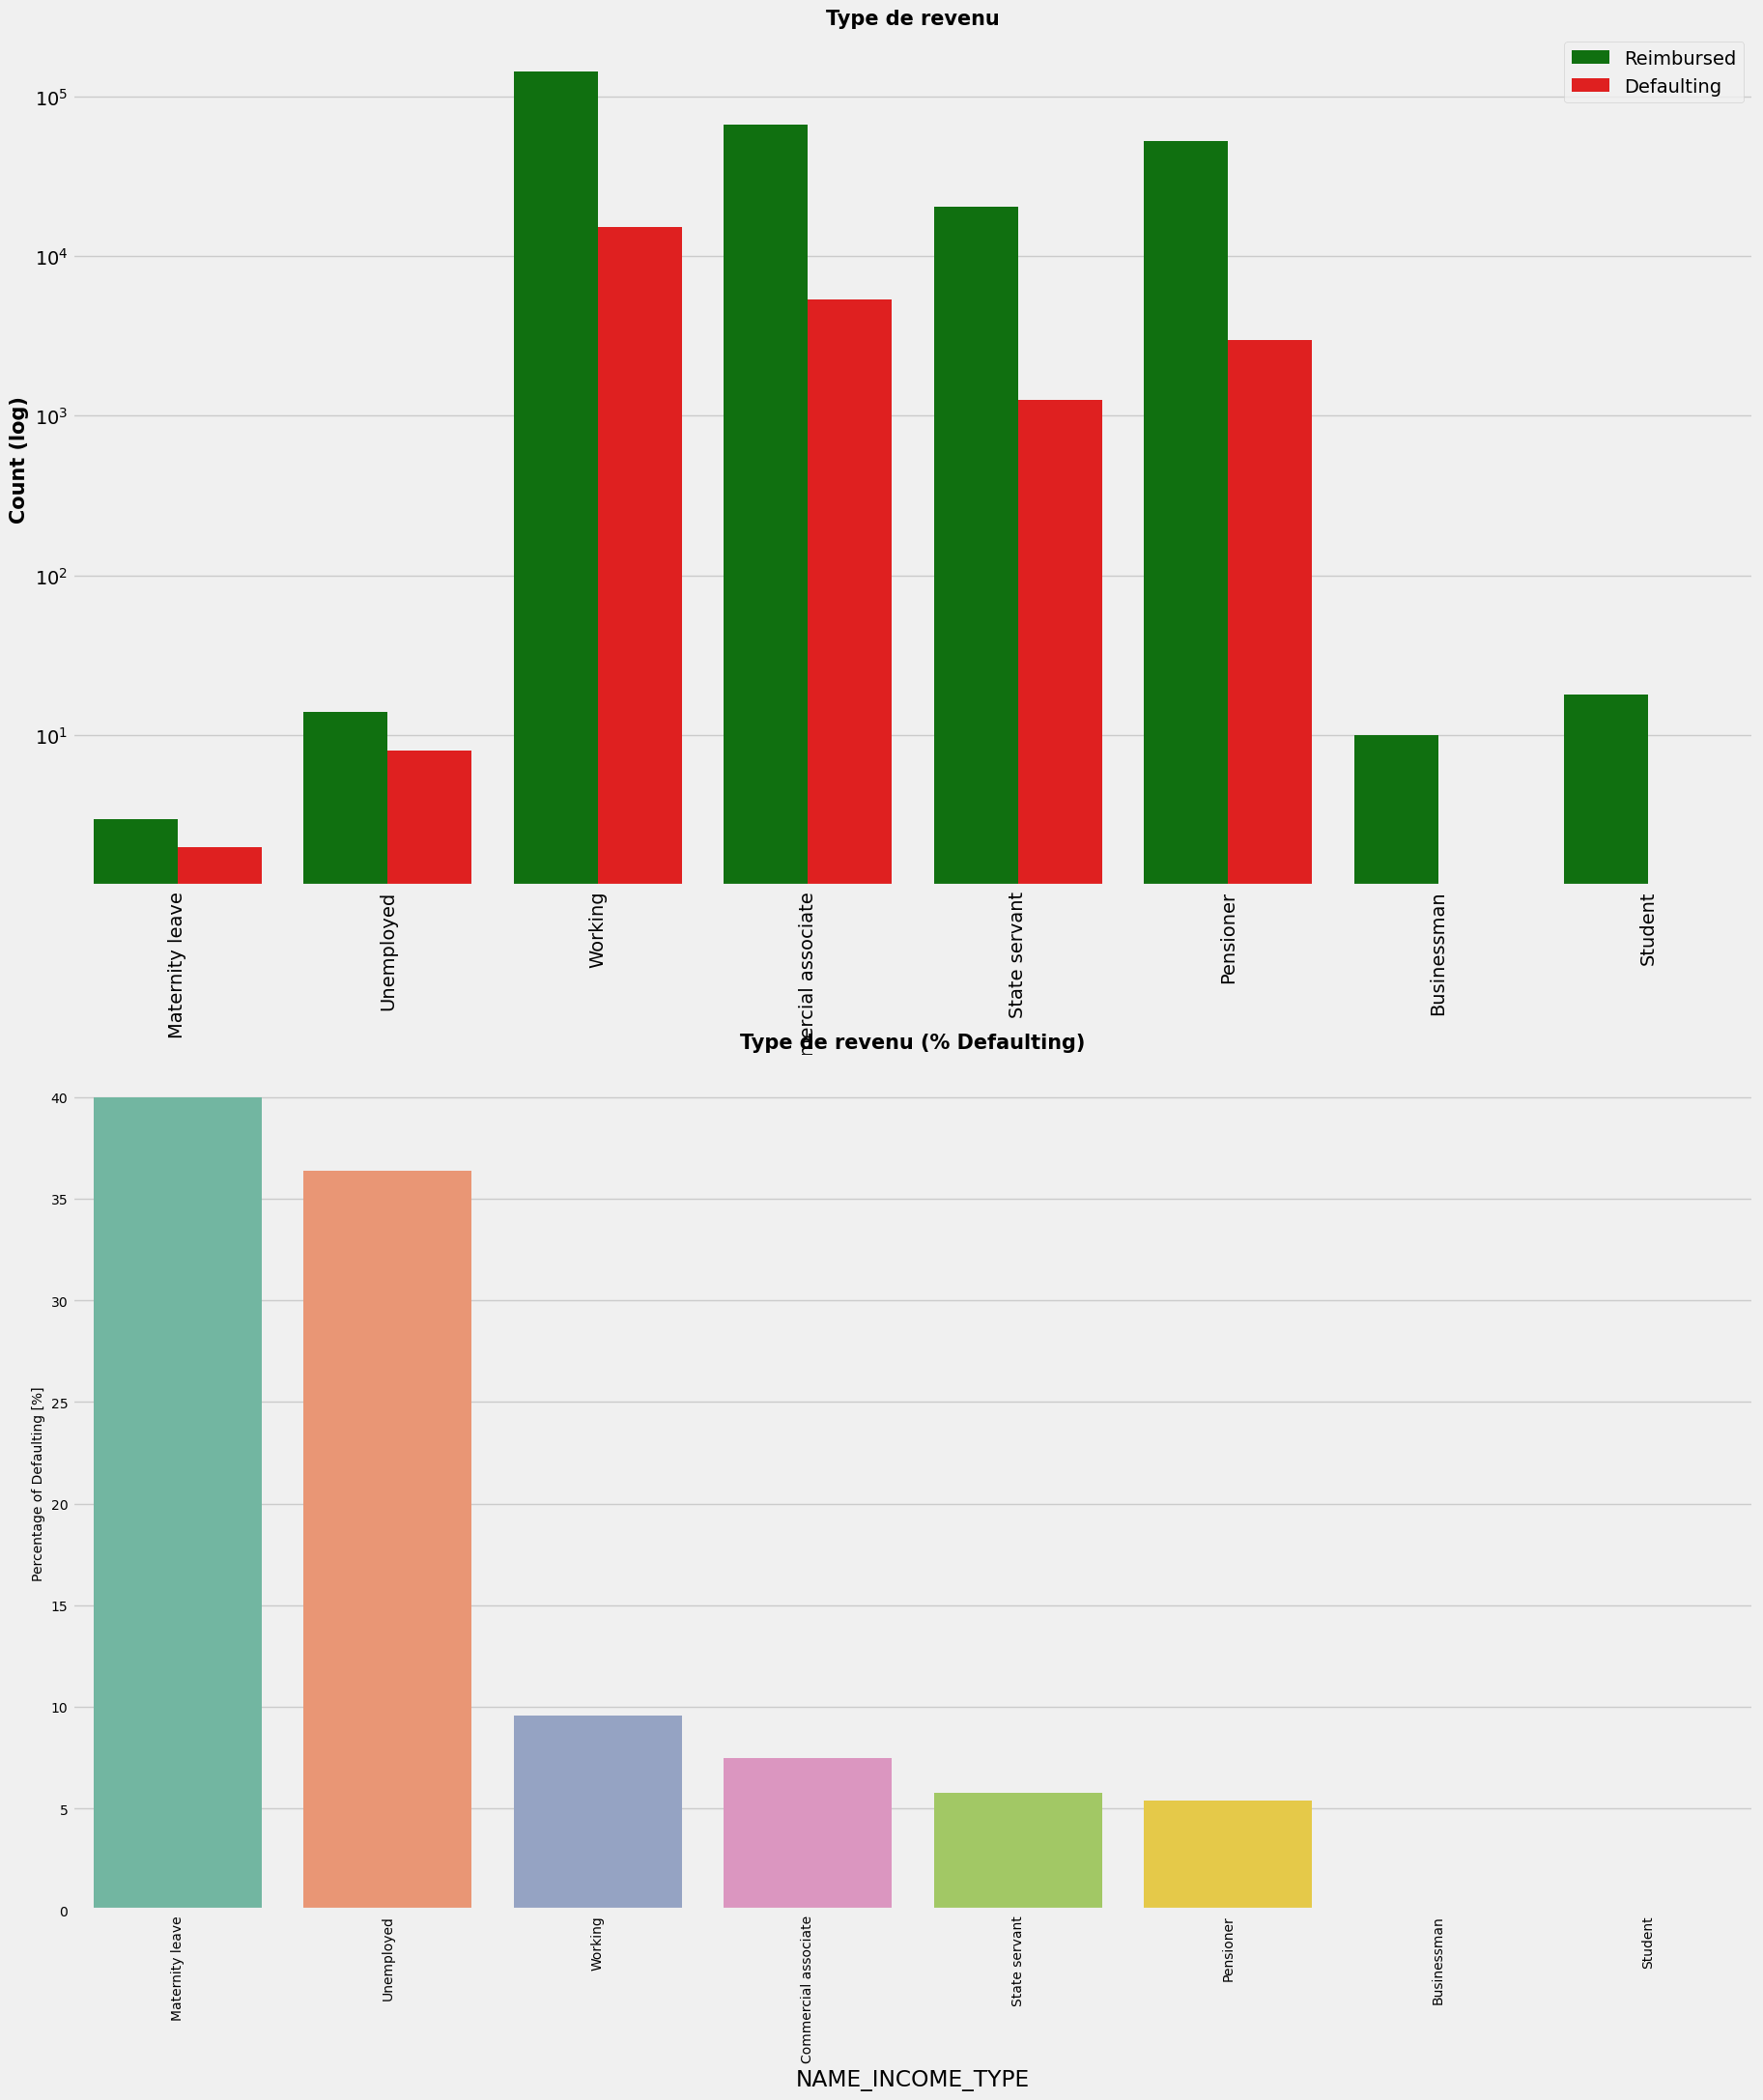

In [75]:
# Analyse de l'impact du type de revenu
# sur de l'état de remboursement du prêt

univariate_categorical(app_train, 'NAME_INCOME_TYPE', "Type de revenu", True,True,False)

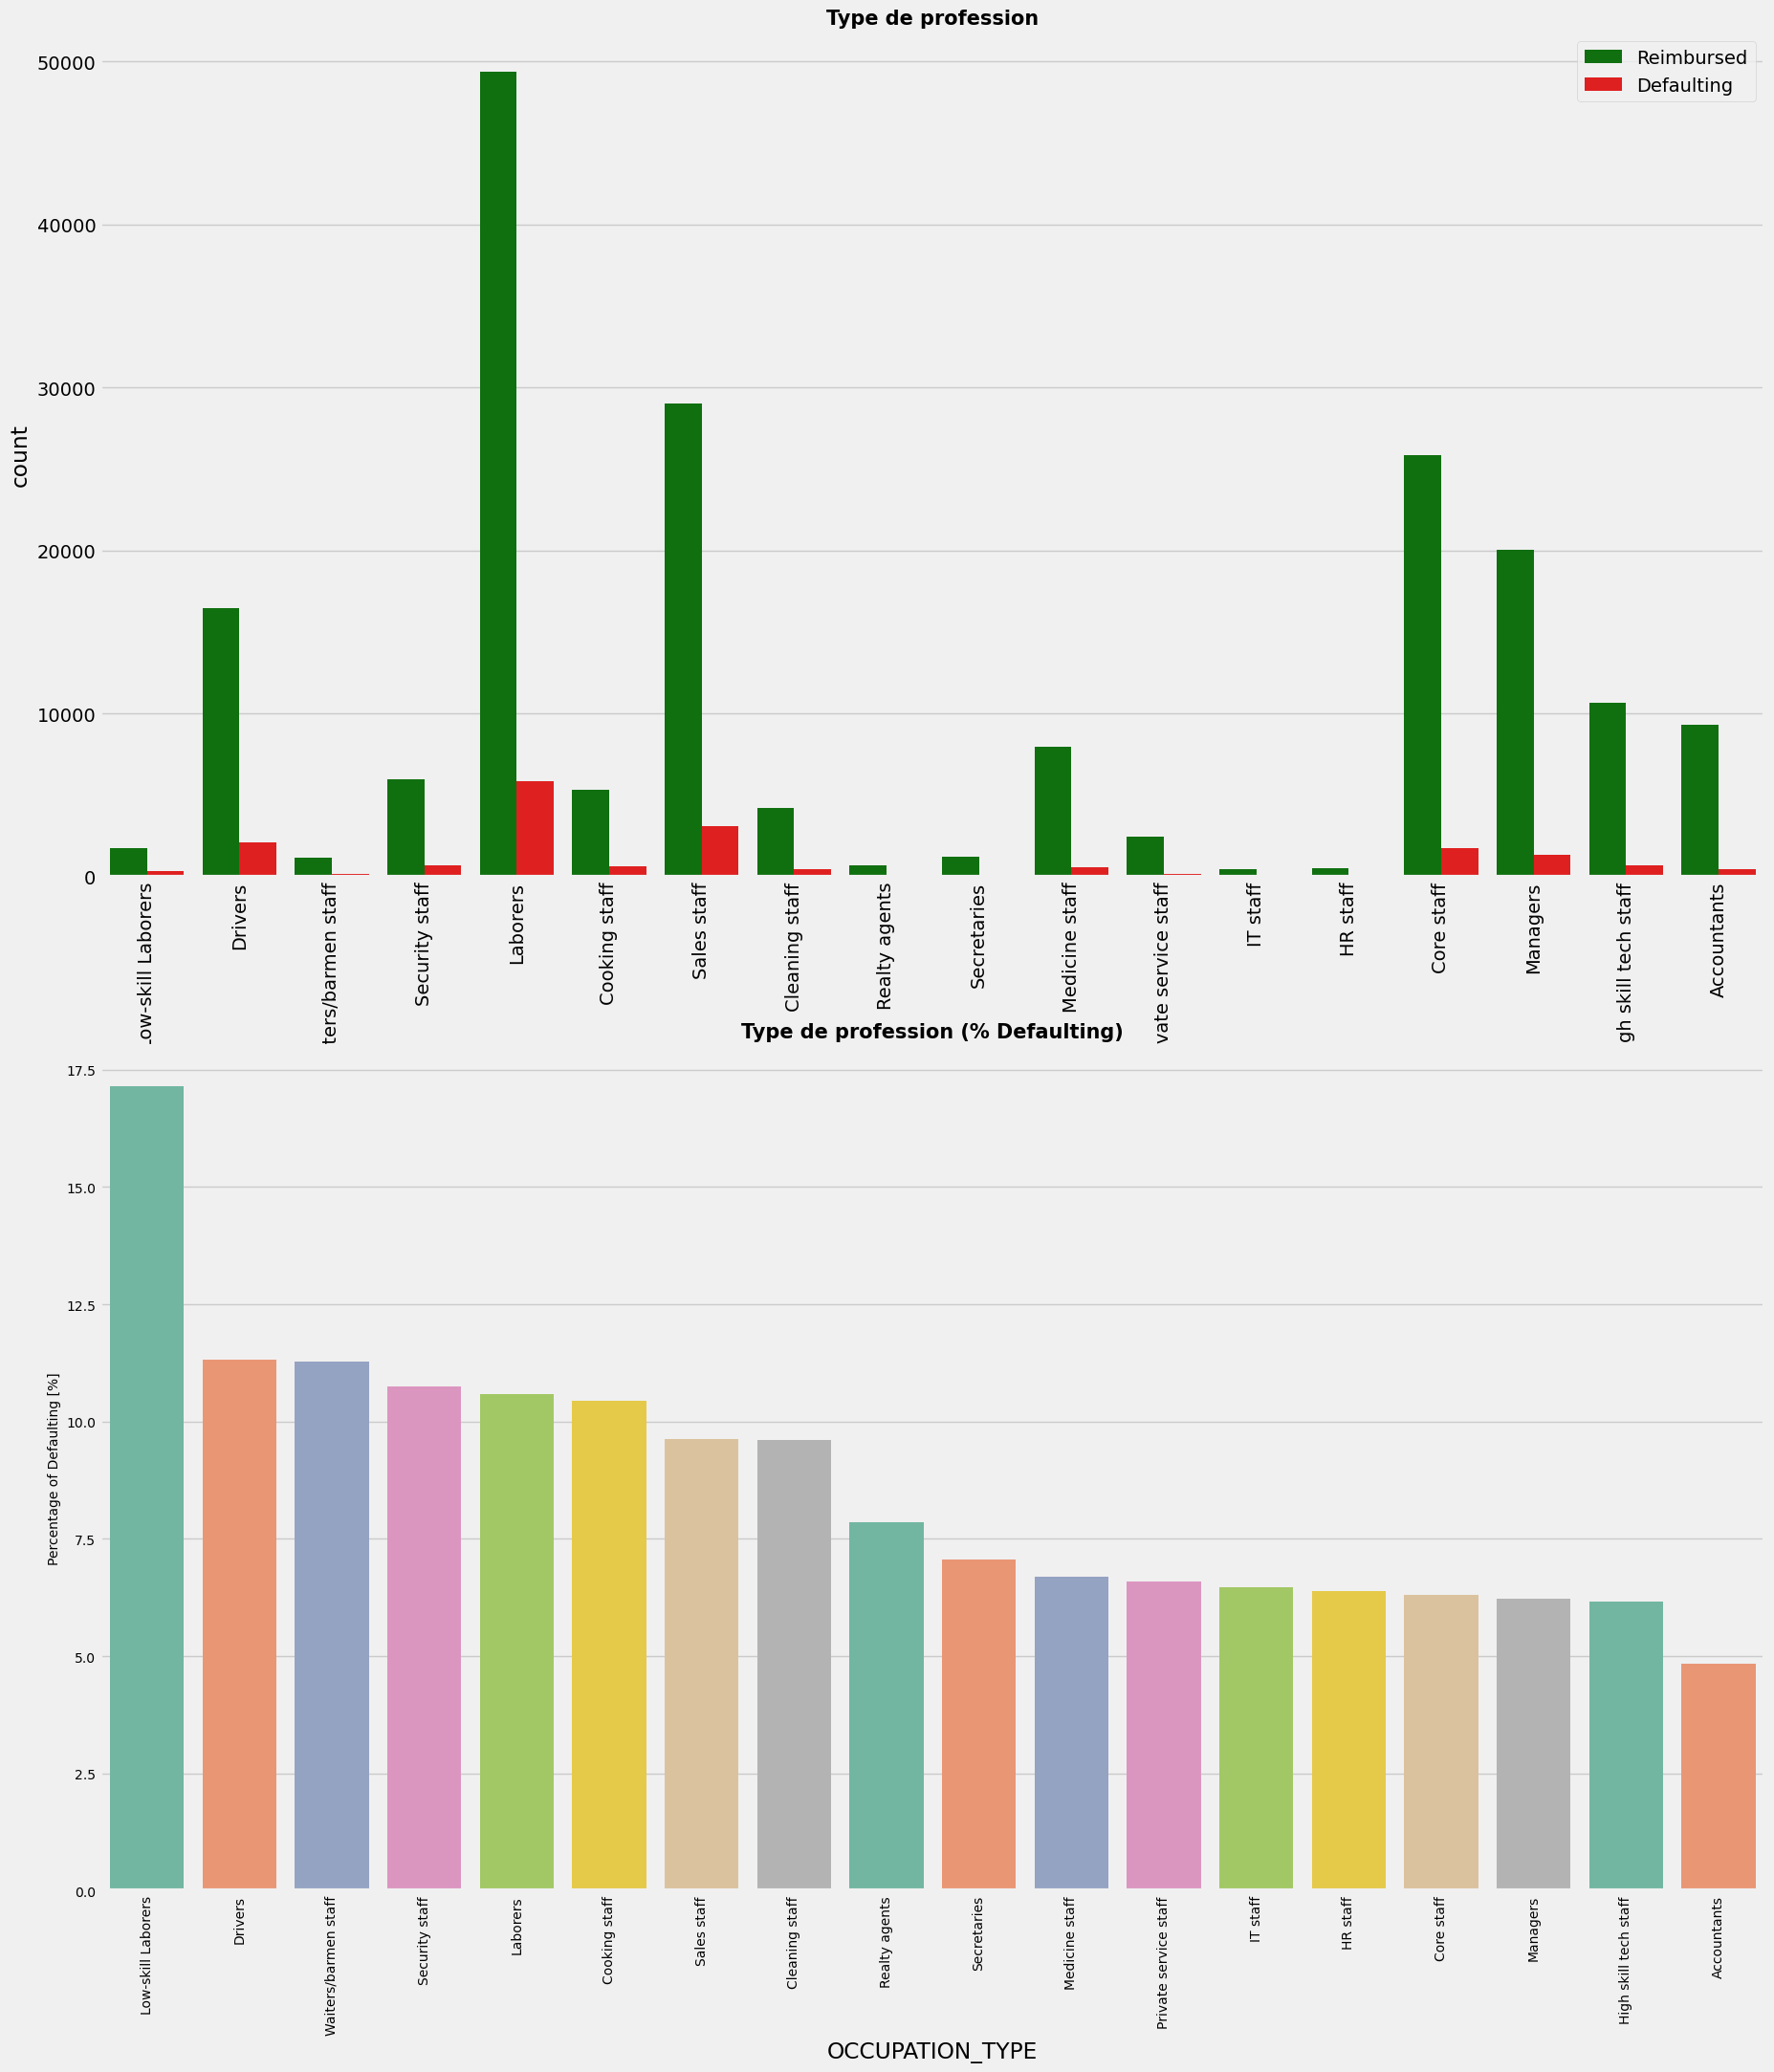

In [76]:
# Analyse de l'impact du type de profession
# sur de l'état de remboursement du prêt

univariate_categorical(app_train, 'OCCUPATION_TYPE', "Type de profession", False,True,False)

### <b> Exterior Sources :<b>

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [77]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

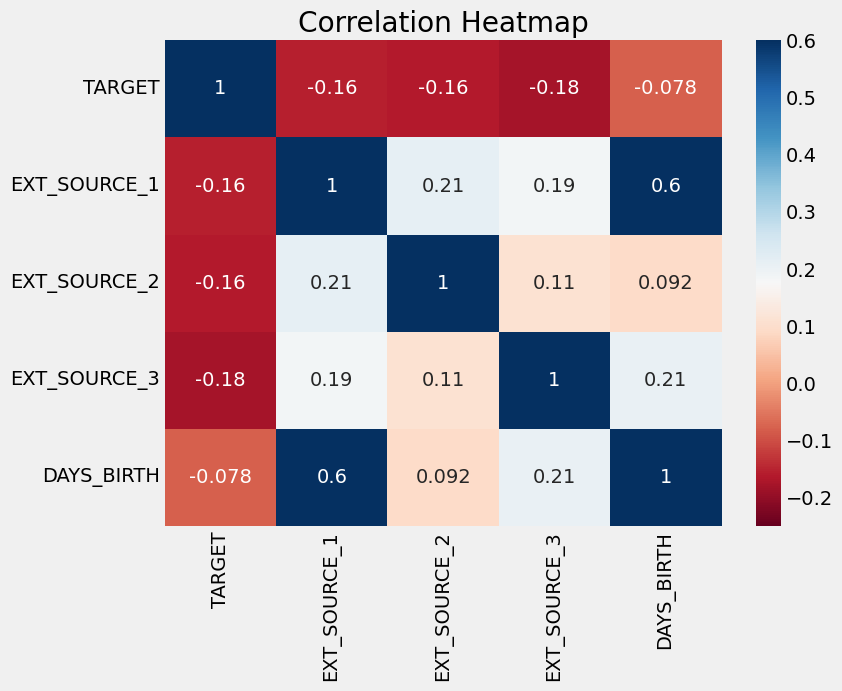

In [78]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdBu, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

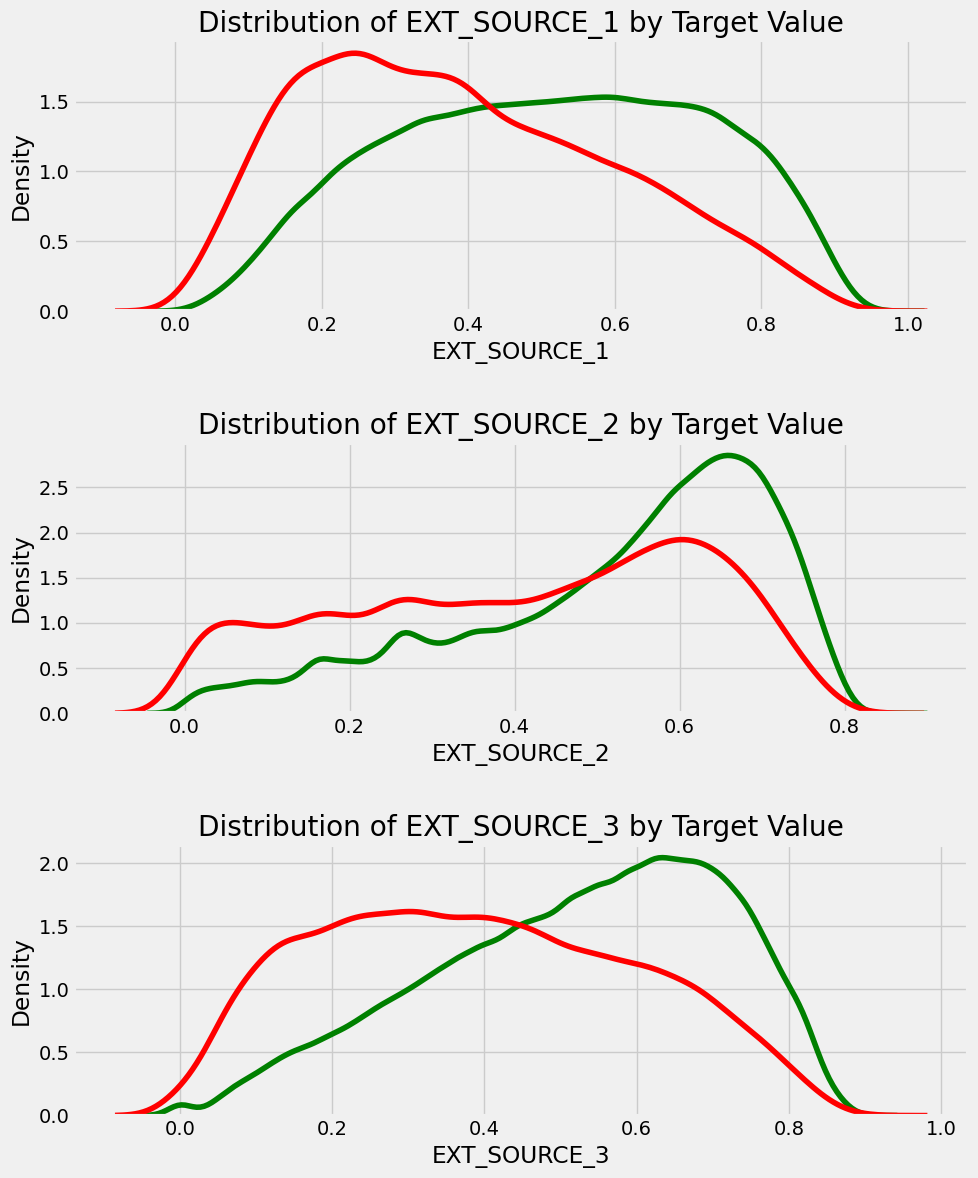

In [79]:

plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], color = "Green", label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], color = "Red", label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    


EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# <b> Feature Engineering : <b>

Le Feature Engineering est déterminant pour la résolution des problèmes de machine learning et l'obtention des meilleurs résultats. Pour ce faire, nous avons adopter l'approche utilisée dans le kernel kaggle suivant:https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/


Les différentes opérations se résument ainsi:

- Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
- Little feature selection is done and overfitting might be a problem since many features are related.
- The following key ideas were used:
 - Divide or subtract important features to get rates (like annuity and income)
 - In Bureau Data: create specific features for Active credits and Closed credits
 - In Previous Applications: create specific features for Approved and Refused applications
 - Modularity: one function for each table (except bureau_balance and application_test)
 - One-hot encoding for categorical features
- All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

A titre d'exemples de création de nouvelles variables:

In [81]:
df=app_train.copy()
# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

In [82]:
# On libère la mémoire après l'analyse exploratoire
del app_train
gc.collect()
del app_test
gc.collect()
del bureau
gc.collect()
del bureau_balance
gc.collect()
del card_balance
gc.collect()
del payments
gc.collect()
del cash_balance
gc.collect()
del prev_app
gc.collect()

0

In [83]:
PATH='/Users/asus2/PROJET7/DONNEES/'

In [84]:
with timer("Process application_train and application_test"):
    df = application_train_test(PATH)
    print("Application df shape:", df.shape)

print("\n--------------------------------\n")
    
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(PATH)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

print("\n--------------------------------\n")

with timer("Process previous_applications"):
    prev = previous_applications(PATH)
    print("Prev applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

print("\n--------------------------------\n")    
    
with timer("Process Cash balance"):
    pos = pos_cash(PATH)
    print("ash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
print("\n--------------------------------\n")

with timer("Process payments"):
    ins = installments_payments(PATH)
    print("payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
print("\n--------------------------------\n")

with timer("Process card balance"):
    cc = credit_card_balance(PATH)
    print("Card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744
Application df shape: (356251, 248)
Process application_train and application_test - done in 4s

--------------------------------

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s

--------------------------------

Prev applications df shape: (338857, 249)
Process previous_applications - done in 15s

--------------------------------

ash balance df shape: (337252, 18)
Process Cash balance - done in 9s

--------------------------------

payments df shape: (339587, 26)
Process payments - done in 21s

--------------------------------

Card balance df shape: (103558, 141)
Process card balance - done in 15s


In [85]:
df.shape

(356251, 798)

In [87]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Data columns (total 798 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    index                                                                  int64  
 1    SK_ID_CURR                                                             int64  
 2    TARGET                                                                 float64
 3    CODE_GENDER                                                            int64  
 4    FLAG_OWN_CAR                                                           int64  
 5    FLAG_OWN_REALTY                                                        int64  
 6    CNT_CHILDREN                                                           int64  
 7    AMT_INCOME_TOTAL                                                       float64
 8    AMT_CREDIT                      

In [88]:
df["ORGANIZATION_TYPE_XNA"].nunique()

2

In [89]:
# Pour que les noms des colonnes soient adéquats (sans espaces)
df.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(), df.columns))

import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [90]:

# Divide in training and test data

features_dropped = ['INDEX']
relevant_features = [col for col in df.columns if col not in features_dropped]

df_train = df[df['TARGET'].notnull()][relevant_features]
df_test = df[df['TARGET'].isnull()]


In [91]:
print("df_train shape :", df_train.shape)
print("df_test shape :", df_test.shape)

df_train shape : (307507, 797)
df_test shape : (48744, 798)


In [92]:
df_train=df_train.set_index('SK_ID_CURR')

In [93]:
df_test=df_test.set_index('SK_ID_CURR')

In [94]:
df_train.head()

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0            0             0                0             0   
100003         0.0            1             0                1             0   
100004         0.0            0             1                0             0   
100006         0.0            1             0                0             0   
100007         0.0            0             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461         -637.0   
100003                        0.003541      -16765        -1188.0   
100004                        0.010032      -19046         -225.0   
100006                        0.008019      -19005        -3039.0   
100007                        0.028663      -19932        -3038.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0            -2120          NaN           1   
100003                -1186.0             -291          NaN           1   
100004                -4260.0            -2531         26.0           1   
100006                -9833.0            -2437          NaN           1   
100007                -4311.0            -3458          NaN           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                   1                0                 1           1   
100003                   1                0                 1           1   
100004                   1                1                 1           1   
100006                   1                0                 1           0   
100007                   1                0                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002               0              1.0                     2   
100003               0              2.0                     1   
100004               0              1.0                     2   
100006               0              2.0                     2   
100007               0              1.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                                2                       10   
100003                                1                       11   
100004                                2                        9   
100006                                2                       17   
100007                                2                       11   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                               0                           0   
100003                               0                           0   
100004                               0                           0   
100006                               0                           0   
100007                       

In [95]:
df_test.head()

INDEX  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                                                              
100001          0     NaN            1             0                0   
100005          1     NaN            0             0                0   
100013          2     NaN            0             1                0   
100028          3     NaN            1             0                0   
100038          4     NaN            0             1                1   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100001                 0          135000.0    568800.0      20560.5   
100005                 0           99000.0    222768.0      17370.0   
100013                 0          202500.0    663264.0      69777.0   
100028                 2          315000.0   1575000.0      49018.5   
100038                 1          180000.0    625500.0      32067.0   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100001             450000.0                    0.018850      -19241   
100005             180000.0                    0.035792      -18064   
100013             630000.0                    0.019101      -20038   
100028            1575000.0                    0.026392      -13976   
100038             625500.0                    0.010032      -13040   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100001            -2329.0            -5170.0             -812          NaN   
100005            -4469.0            -9118.0            -1623          NaN   
100013            -4458.0            -2175.0            -3503          5.0   
100028            -1866.0            -2000.0            -4208          NaN   
100038            -2191.0            -4000.0            -4262         16.0   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100001               1               1                0                 1   
100005               1               1                0                 1   
100013               1               1                0                 1   
100028               1               1                0                 1   
100038               1               1                1                 1   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
100001               0           1              2.0                     2   
100005               0           0              2.0                     2   
100013               0           0              2.0                     2   
100028               1           0              4.0                     2   
100038               0           0              3.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100001                                2                       18   
100005                                2                        9   
100013                                2                       14   
100028                                2                       11   
100038                                2                        5   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100001                               0                           0   
100005                               0                           0   
100013                               0                           0   
100028                               0            

In [96]:
df_test.shape

(48744, 797)

In [97]:
df_test.head()

INDEX  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                                                              
100001          0     NaN            1             0                0   
100005          1     NaN            0             0                0   
100013          2     NaN            0             1                0   
100028          3     NaN            1             0                0   
100038          4     NaN            0             1                1   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100001                 0          135000.0    568800.0      20560.5   
100005                 0           99000.0    222768.0      17370.0   
100013                 0          202500.0    663264.0      69777.0   
100028                 2          315000.0   1575000.0      49018.5   
100038                 1          180000.0    625500.0      32067.0   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100001             450000.0                    0.018850      -19241   
100005             180000.0                    0.035792      -18064   
100013             630000.0                    0.019101      -20038   
100028            1575000.0                    0.026392      -13976   
100038             625500.0                    0.010032      -13040   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100001            -2329.0            -5170.0             -812          NaN   
100005            -4469.0            -9118.0            -1623          NaN   
100013            -4458.0            -2175.0            -3503          5.0   
100028            -1866.0            -2000.0            -4208          NaN   
100038            -2191.0            -4000.0            -4262         16.0   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100001               1               1                0                 1   
100005               1               1                0                 1   
100013               1               1                0                 1   
100028               1               1                0                 1   
100038               1               1                1                 1   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
100001               0           1              2.0                     2   
100005               0           0              2.0                     2   
100013               0           0              2.0                     2   
100028               1           0              4.0                     2   
100038               0           0              3.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100001                                2                       18   
100005                                2                        9   
100013                                2                       14   
100028                                2                       11   
100038                                2                        5   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100001                               0                           0   
100005                               0                           0   
100013                               0                           0   
100028                               0            

In [98]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 100002 to 456255
Data columns (total 796 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    TARGET                                                                 float64
 1    CODE_GENDER                                                            int64  
 2    FLAG_OWN_CAR                                                           int64  
 3    FLAG_OWN_REALTY                                                        int64  
 4    CNT_CHILDREN                                                           int64  
 5    AMT_INCOME_TOTAL                                                       float64
 6    AMT_CREDIT                                                             float64
 7    AMT_ANNUITY                                                            float64
 8    AMT_GOODS_PRICE            

In [99]:
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 797 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    INDEX                                                                  int64  
 1    TARGET                                                                 float64
 2    CODE_GENDER                                                            int64  
 3    FLAG_OWN_CAR                                                           int64  
 4    FLAG_OWN_REALTY                                                        int64  
 5    CNT_CHILDREN                                                           int64  
 6    AMT_INCOME_TOTAL                                                       float64
 7    AMT_CREDIT                                                             float64
 8    AMT_ANNUITY                 

In [100]:
del df
gc.collect()

0

# <b> Modélisation :<b>

Pour trouver la meilleure modélisation de notre problème, nous allons comparer les algorithmes suivants:
- Logistic regression
- RandomForest Classifier
- ExtraTrees Classifier
- LightGBM

Nous examinons les performences de ces algorithmes en les comparant à celle d'une baseline DummyClassifier avec la stratégie "most_frequent" pour prédire systématiquement la classe la plus fréquente.

Ces différents modèles sont évaluées via une cross-validation et leurs hyperparamètres optimisés à l'aide d'une GridSearchCV.

### <b> Métrique d'évaluation :<b>

Nous avons à traiter un problème de classification binaire déquilibrée. Les modèles considérés seront évalués avec la métrique suivante:

**- AUC:**  Aire sous la courbe ROC qui est la mesure de la capacité d'un classifieur à distinguer les classes. Plus l'AUC est élevée, plus le modèle est capable à prédire les classes positives et négatives correctement.    

### <b> Gestion des données déséquilibrées: (Resampling)<b>

D'après l'analyse exploratoire, nous avon vu que le jeu de données est très déséquilibré. Pour la variable 'TARGET', plus de 90% des crédits ont été remboursés.

Il existe trois techniques pour resampler les données:

**-Undersampling:** on enlève des individus de la classe majoritaire

**-Oversampling:** on rajoute des individus dans la classe majoritaire

**-Combinaison des deux:** on effectue successivement undersampling suivi de oversampling ou le contraire pour pallier au déséquilibre des données.
    

Pour l'oversampling, nous allons utiliser l'algorithme **SMOTE** dont les étapes sont :

**1**- Sélectionnez une classe minoritaire comme vecteur d'entrée

**2**-Trouvez ses k voisins les plus proches 
 (k_neighbors est spécifié comme argument dans la fonction **SMOTE()**)

**3**-Choisissez un de ces voisins et placez un point synthétique n'importe 
où sur la ligne joignant le point considéré et son voisin choisi

**4**-Répétez les étapes jusqu'à ce que les données soient équilibrées


**- SMOTETomek:** est une variante de Smote...

### <b>Sampling of Data : <b>

In [101]:
# Sampling
data = df_train.sample(20000, random_state=42)

In [102]:
data.head(3)

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
369780         0.0            1             0                0             2   
405321         0.0            1             0                1             0   
142233         0.0            0             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
369780               72000.0    198666.0      15696.0         175500.0   
405321              221400.0    247500.0       9814.5         247500.0   
142233              360000.0    521136.0      54855.0         495000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
369780                        0.025164       -9267        -2602.0   
405321                        0.015221      -10916         -810.0   
142233                        0.046220      -10066        -1273.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
369780                 -372.0             -785          NaN           1   
405321                 -532.0            -3534          NaN           1   
142233                -4059.0            -2511          NaN           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
369780                   1                0                 1           0   
405321                   1                0                 1           0   
142233                   1                0                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
369780               0              4.0                     2   
405321               0              2.0                     2   
142233               0              2.0                     1   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
369780                                2                       15   
405321                                2                       13   
142233                                1                       14   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
369780                               0                           0   
405321                               0                           0   
142233                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
369780                                0                       0   
405321                                0                       0   
142233                                0                       1   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
SK_ID_CURR                                                                  
369780                           0                        0      0.044202   
405321                           0                        0      0.543037   
142233                           1                        1           NaN   

            EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
SK_ID_CURR                                                                 
369780          0.544933           NaN          0.4928            0.2583   
405321          0.587365      0.692559          0.2598               NaN   
142233          0.643635           NaN             NaN               NaN   

           

In [103]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 369780 to 225379
Data columns (total 796 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    TARGET                                                                 float64
 1    CODE_GENDER                                                            int64  
 2    FLAG_OWN_CAR                                                           int64  
 3    FLAG_OWN_REALTY                                                        int64  
 4    CNT_CHILDREN                                                           int64  
 5    AMT_INCOME_TOTAL                                                       float64
 6    AMT_CREDIT                                                             float64
 7    AMT_ANNUITY                                                            float64
 8    AMT_GOODS_PRICE             

### <b> Séparation des données : <b>

Dans la suite nous utilisons le dataframe 'df_train' après suppression de la variable 'TARGET', en le séparant en données d'entrainement et données de test. 

In [104]:
Y = data["TARGET"]
X = data.drop("TARGET", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, random_state=42, 
                                                    stratify=Y, shuffle=True)

columns=X_train.columns  #  storing features names


In [105]:
print("Entrainement: {},\nTest: {} .\n".format(X_train.shape,
                                                            X_test.shape))

Entrainement: (16000, 795),
Test: (4000, 795) .



In [106]:
X_train.isnull().sum()

CODE_GENDER                                                                  0
FLAG_OWN_CAR                                                                 0
FLAG_OWN_REALTY                                                              0
CNT_CHILDREN                                                                 0
AMT_INCOME_TOTAL                                                             0
AMT_CREDIT                                                                   0
AMT_ANNUITY                                                                  0
AMT_GOODS_PRICE                                                             13
REGION_POPULATION_RELATIVE                                                   0
DAYS_BIRTH                                                                   0
DAYS_EMPLOYED                                                             2897
DAYS_REGISTRATION                                                            0
DAYS_ID_PUBLISH                                     

In [107]:
X_train.isnull().sum().sum()

3315756

In [108]:
X_test.isnull().sum()

CODE_GENDER                                                                 0
FLAG_OWN_CAR                                                                0
FLAG_OWN_REALTY                                                             0
CNT_CHILDREN                                                                0
AMT_INCOME_TOTAL                                                            0
AMT_CREDIT                                                                  0
AMT_ANNUITY                                                                 0
AMT_GOODS_PRICE                                                             2
REGION_POPULATION_RELATIVE                                                  0
DAYS_BIRTH                                                                  0
DAYS_EMPLOYED                                                             754
DAYS_REGISTRATION                                                           0
DAYS_ID_PUBLISH                                                 

In [109]:
X_test.isnull().sum().sum()

825610

In [110]:
y_train.value_counts()

0.0    14675
1.0     1325
Name: TARGET, dtype: int64

In [111]:
y_train.nunique()

2

In [112]:
y_test.value_counts()

0.0    3669
1.0     331
Name: TARGET, dtype: int64

In [113]:
y_test.nunique()

2

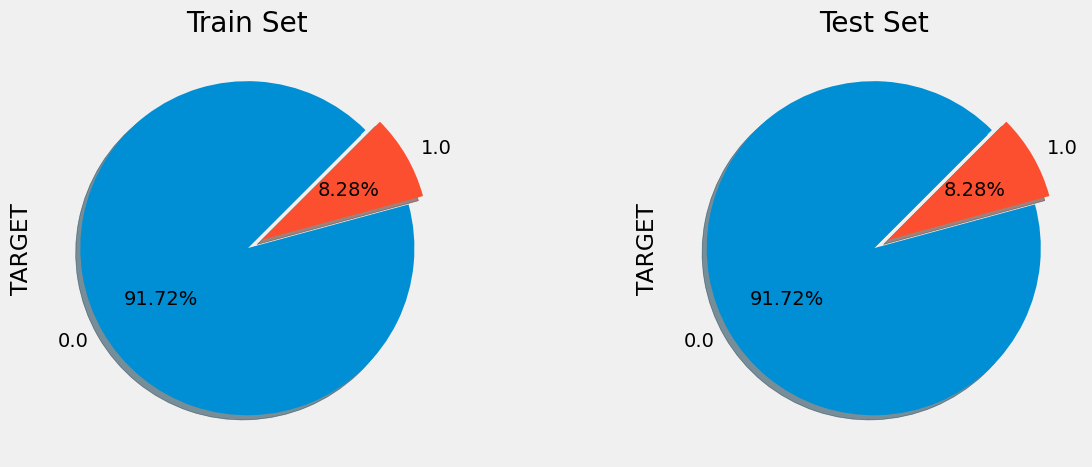

In [114]:
# Display proportion of target value in both train and test set
#Creating explode data
explode = (0.0, 0.1)
fig, ax = plt.subplots(1,2, figsize=(12,8))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0],explode = explode,shadow=True, startangle=45, title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1],explode = explode,shadow=True, startangle=45, title='Test Set')
fig.subplots_adjust(wspace=0.5)

#### <b> Imputation of missing values: <b>

In [115]:
from sklearn.impute import SimpleImputer

# Mean imputation
imputer=SimpleImputer(missing_values=np.nan, strategy='median')


In [116]:
# Fit the training data
X_train[X_train==np.inf]=np.nan
imputer.fit(X_train)

SimpleImputer(strategy='median')

In [117]:
# Fit the test data  

X_test[X_test==np.inf] = np.nan


In [118]:
# Transform training data

X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

In [119]:
np.isnan(X_train_imp).sum()

0

In [120]:
np.isnan(X_test_imp).sum()

0

#### <b> Scaling of data: <b>

In [121]:
# Scale each feature to 0-1
#scaler = MinMaxScaler(feature_range = (0, 1))

#Robust scaler
scaler = RobustScaler()

# Repeat with the scaler
scaler.fit(X_train_imp)
#scaler.fit(X_test_imp)
X_train_imp  = scaler.transform(X_train_imp)
X_test_imp = scaler.transform(X_test_imp)

In [122]:
X_test.head()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
329363                0             0                1             1   
396164                0             1                0             0   
293880                0             1                0             0   
110382                1             0                1             0   
130594                1             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
329363              270000.0    180000.0       9000.0         180000.0   
396164               67500.0    889515.0      26005.5         742500.0   
293880               81000.0    533668.5      23638.5         477000.0   
110382               85500.0    819792.0      39568.5         720000.0   
130594              108000.0    225000.0      12694.5         225000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
329363                        0.020246      -10524         -669.0   
396164                        0.015221      -18145        -3604.0   
293880                        0.025164      -21569            NaN   
110382                        0.018634      -16391        -5707.0   
130594                        0.009657      -24291            NaN   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
329363                -4532.0            -2892          NaN           1   
396164                -5484.0            -1704         16.0           1   
293880                -2053.0            -4200         12.0           1   
110382                -3345.0            -4547          NaN           1   
130594                -3477.0            -5099          NaN           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
329363                   1                1                 1           0   
396164                   1                1                 1           1   
293880                   0                0                 1           0   
110382                   1                1                 1           1   
130594                   0                0                 1           1   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
329363               0              2.0                     3   
396164               0              2.0                     2   
293880               0              2.0                     2   
110382               0              2.0                     2   
130594               0              1.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
329363                                3                       11   
396164                                2                       10   
293880                                2                       14   
110382                                2                       11   
130594                                2                       10   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
329363                               0                           0   
396164                               0                           0   
293880                               0                           0   
110382                               0                           0   
130594                               0                           0   

            LI

In [123]:
X_test.shape

(4000, 795)

In [124]:
X_train.shape

(16000, 795)

In [125]:
X_train.head()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
410941                1             0                0             0   
179544                1             1                0             0   
244610                1             0                0             1   
128609                0             0                0             0   
395575                1             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
410941               94500.0    253737.0      24849.0         229500.0   
179544              175950.0    501363.0      27328.5         418500.0   
244610              225000.0    779688.0      39937.5         630000.0   
128609               76950.0    239850.0      23364.0         225000.0   
395575              180000.0   1288350.0      37053.0        1125000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
410941                        0.025164      -13515        -3048.0   
179544                        0.022800      -18252        -8017.0   
244610                        0.007020       -9197         -943.0   
128609                        0.030755      -22820            NaN   
395575                        0.046220      -13457         -736.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
410941                -6650.0             -315          NaN           1   
179544                -8017.0            -1804         12.0           1   
244610                 -899.0            -1873          NaN           1   
128609               -15224.0            -4354          NaN           1   
395575                -7609.0            -2684          NaN           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
410941                   1                0                 1           0   
179544                   1                0                 1           0   
244610                   1                0                 1           0   
128609                   0                0                 1           0   
395575                   1                0                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
410941               0              2.0                     2   
179544               0              2.0                     2   
244610               0              3.0                     2   
128609               0              2.0                     2   
395575               0              2.0                     1   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
410941                                2                       16   
179544                                2                        8   
244610                                2                       12   
128609                                2                       11   
395575                                1                       17   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
410941                               0                           0   
179544                               0                           0   
244610                               0                           0   
128609                               0                           0   
395575                               0                           0   

            LI

In [126]:
X_train_imp.shape

(16000, 795)

In [127]:
X_test_imp.shape

(4000, 795)

In [129]:
xtrain = pd.DataFrame(scaler.transform(X_train_imp), index=X_train.index, columns=X_train.columns)
xtest = pd.DataFrame(scaler.transform(X_test_imp), index=X_test.index, columns=X_test.columns)

In [130]:
print(" columns wich are differents in xtrain and xtrain_us.")
display(xtrain.columns.difference(xtest.columns))

 columns wich are differents in xtrain and xtrain_us.


Index([], dtype='object')

In [131]:
set(xtrain.columns).difference(set(xtest.columns))

set()

In [132]:
display(xtest.columns.difference(xtrain.columns))

Index([], dtype='object')

In [133]:
set(xtest.columns).difference(set(xtrain.columns))

set()

In [134]:
print("xtrain shape :",xtrain.shape)
print("xtest shape :",xtest.shape)
print("y_train shape :", y_train.shape)
print("y_test shape :", y_test.shape)



xtrain shape : (16000, 795)
xtest shape : (4000, 795)
y_train shape : (16000,)
y_test shape : (4000,)


In [135]:
xtrain.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_NAME_CONTRACT_STATUS_SIGNED_MAX',
       'CC_NAME_CONTRACT_STATUS_SIGNED_MEAN',
       'CC_NAME_CONTRACT_STATUS_SIGNED_SUM',
       'CC_NAME_CONTRACT_STATUS_SIGNED_VAR', 'CC_NAME_CONTRACT_STATUS_NAN_MIN',
       'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_NAN_SUM', 'CC_NAME_CONTRACT_STATUS_NAN_VAR',
       'CC_COUNT'],
      dtype='object', length=795)

In [136]:
xtest.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_NAME_CONTRACT_STATUS_SIGNED_MAX',
       'CC_NAME_CONTRACT_STATUS_SIGNED_MEAN',
       'CC_NAME_CONTRACT_STATUS_SIGNED_SUM',
       'CC_NAME_CONTRACT_STATUS_SIGNED_VAR', 'CC_NAME_CONTRACT_STATUS_NAN_MIN',
       'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_NAN_SUM', 'CC_NAME_CONTRACT_STATUS_NAN_VAR',
       'CC_COUNT'],
      dtype='object', length=795)

In [137]:
y_train.shape

(16000,)

In [138]:
y_test.shape

(4000,)

In [139]:
y_test.head(2)

SK_ID_CURR
329363    0.0
396164    1.0
Name: TARGET, dtype: float64

In [140]:

# Définition du df_test_output pour l'API

df_test_output=xtest
df_test_output['TARGET']=y_test



## <b> Models training:<b>

In [141]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method", "AUC", "AUC_test", "Time"])


In [142]:
# define smote strategy
smote = SMOTE(random_state=42)
# Define SMOTE-Tomek Links (Over-sampling followed by under-sampling)
smotetomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')


In [143]:
#Undersampling
#rus = RandomUnderSampler(random_state=6)
rus = RandomUnderSampler(sampling_strategy='majority')
xtrain_us, ytrain_us = rus.fit_resample(xtrain, y_train)


In [144]:
#Oversampling
#smote = SMOTE(random_state=6)
smote = SMOTE(random_state=42)
xtrain_os, ytrain_os = smote.fit_resample(xtrain, y_train)

In [145]:
#SMOTETomek
smotetomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
xtrain_smotetomek, ytrain_smotetomek = smotetomek.fit_resample(xtrain, y_train)

### <b>Baseline :<b>

In [146]:
DC1 = DummyClassifier(strategy="most_frequent")
DC2 = DummyClassifier(strategy="stratified")

### <b> Undersampling :<b>

In [147]:
row = evaluate_model(DC1, xtrain_us, ytrain_us, xtest, y_test, "Baseline", "Undersampling")

In [148]:
print(row)

['Baseline', 'Undersampling', 0.5, 0.5, 0.0007350444793701172]


In [149]:
results.loc[len(results)] = row
results

Algorithm Balancing_method  AUC  AUC_test      Time
0  Baseline    Undersampling  0.5       0.5  0.000735

### <b> Oversampling : SMOTE<b>

In [150]:
row = evaluate_model(DC1, xtrain_os, ytrain_os, xtest, y_test, "Baseline", "smote")


In [151]:
results.loc[len(results)] = row
results

Algorithm Balancing_method  AUC  AUC_test      Time
0  Baseline    Undersampling  0.5       0.5  0.000735
1  Baseline            smote  0.5       0.5  0.001255

### <b> SMOTETomek  : <b>

In [152]:
row = evaluate_model(DC2, xtrain_smotetomek, ytrain_smotetomek, xtest, y_test, "Baseline", "smotetomek")

In [153]:

results.loc[len(results)] = row
results


Algorithm Balancing_method    AUC  AUC_test      Time
0  Baseline    Undersampling  0.500     0.500  0.000735
1  Baseline            smote  0.500     0.500  0.001255
2  Baseline       smotetomek  0.497     0.512  0.001756

## <b>Logistic Regression :<b>

### <b> Undersampling:<b>

In [154]:
clf=LogisticRegression(random_state=0)

In [155]:
lr_us = Pipeline(steps=[('sampling', RandomUnderSampler(sampling_strategy='majority')),('clf', clf)])

In [156]:

params = {
    'clf__penalty': ['l2'],
    "clf__C": [0.01, 0.1, 1, 2, 10, 100]
        }

hgs_lr_us = HalvingGridSearchCV(lr_us, 
                             param_grid=params, 
                             cv=5, 
                           #  max_resources=20,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )

In [157]:
xtrain_us.shape

(2650, 795)

In [158]:
ytrain_us.shape

(2650,)

In [159]:
xtest.shape

(4000, 796)

In [160]:
xtest.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_NAME_CONTRACT_STATUS_SIGNED_MEAN',
       'CC_NAME_CONTRACT_STATUS_SIGNED_SUM',
       'CC_NAME_CONTRACT_STATUS_SIGNED_VAR', 'CC_NAME_CONTRACT_STATUS_NAN_MIN',
       'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_NAN_SUM', 'CC_NAME_CONTRACT_STATUS_NAN_VAR',
       'CC_COUNT', 'TARGET'],
      dtype='object', length=796)

In [161]:
xtest.drop('TARGET', axis=1, inplace=True)

In [162]:
row = evaluate_model(hgs_lr_us, xtrain_us, ytrain_us, xtest, y_test, "LogisticRegression", "Undersampling")

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [163]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_lr_us.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_lr_us.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__C': 10, 'clf__penalty': 'l2'}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.535819039451115


In [164]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test      Time
0            Baseline    Undersampling  0.500     0.500  0.000735
1            Baseline            smote  0.500     0.500  0.001255
2            Baseline       smotetomek  0.497     0.512  0.001756
3  LogisticRegression    Undersampling  0.536     0.536  7.402356

### <b> Oversampling: SMOTE<b>

In [165]:
lr_smote = Pipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])


params = {
    'clf__penalty': ['l2'],
    'clf__C': [0.01, 0.1, 1, 2, 10, 100]
}


In [166]:

hgs_lr_os = HalvingGridSearchCV(lr_smote, 
                             param_grid=params, 
                             cv=5, 
                            # max_resources=30,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1,
                             error_score='raise'
                            )


In [167]:

row = evaluate_model(hgs_lr_os, xtrain_os, ytrain_os, xtest, y_test, "LogisticRegression", "smote")

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [168]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print(hgs_lr_os.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_lr_os.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__C': 100, 'clf__penalty': 'l2'}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.5565595282472195


In [169]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test       Time
0            Baseline    Undersampling  0.500     0.500   0.000735
1            Baseline            smote  0.500     0.500   0.001255
2            Baseline       smotetomek  0.497     0.512   0.001756
3  LogisticRegression    Undersampling  0.536     0.536   7.402356
4  LogisticRegression            smote  0.557     0.538  87.845842

### <b> SMOTETomek   : <b>

In [170]:


params = {
    'clf__penalty': ['l2'],
    'clf__C': [0.01, 0.1, 1, 2, 10, 100]
}




In [171]:

lr_smotetomek = Pipeline([
        ('sampling', SMOTETomek(random_state=6)),
        ('clf', LogisticRegression())
    ])



In [172]:
hgs_lr_smotetomek = HalvingGridSearchCV(lr_smotetomek, 
                             param_grid=params, 
                             cv=5,
                            # max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )

In [174]:
row = evaluate_model(hgs_lr_smotetomek, xtrain_smotetomek, ytrain_smotetomek, xtest, y_test, "LogisticRegression", "smotetomek")

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [175]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print(hgs_lr_smotetomek.best_params_) 
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_lr_smotetomek.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__C': 0.1, 'clf__penalty': 'l2'}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.5552044949582882


In [176]:

results.loc[len(results)] = row
results


Algorithm Balancing_method    AUC  AUC_test        Time
0            Baseline    Undersampling  0.500     0.500    0.000735
1            Baseline            smote  0.500     0.500    0.001255
2            Baseline       smotetomek  0.497     0.512    0.001756
3  LogisticRegression    Undersampling  0.536     0.536    7.402356
4  LogisticRegression            smote  0.557     0.538   87.845842
5  LogisticRegression       smotetomek  0.555     0.537  310.855603

## <b> RandomForest Classifier :<b>

### <b> Undersampling:<b>

In [177]:
rfc = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=8, min_samples_split=2, min_samples_leaf=1, bootstrap=False)


In [178]:
 param_grid = { 
    'n_estimators': [150],
    'max_features': ['auto']
}

In [179]:


hgs_rf_us=HalvingGridSearchCV(rfc, 
                             param_grid=param_grid, 
                             cv=5,
                           #  max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )



In [180]:

row = evaluate_model(hgs_rf_us, xtrain_us, ytrain_us, xtest, y_test, "RandomForest", "Undersampling")


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

In [181]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_rf_us.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_rf_us.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'max_features': 'auto', 'n_estimators': 150}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7121936632253472


In [182]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test        Time
0            Baseline    Undersampling  0.500     0.500    0.000735
1            Baseline            smote  0.500     0.500    0.001255
2            Baseline       smotetomek  0.497     0.512    0.001756
3  LogisticRegression    Undersampling  0.536     0.536    7.402356
4  LogisticRegression            smote  0.557     0.538   87.845842
5  LogisticRegression       smotetomek  0.555     0.537  310.855603
6        RandomForest    Undersampling  0.712     0.737    4.047397

### <b> Oversampling: SMOTE<b>

In [183]:

model = Pipeline([
        ('sampling', SMOTE()),
        ('clf',  RandomForestClassifier(n_estimators=150, max_features='auto', n_jobs=-1,oob_score = True))
    ])


params = {
   # 'clf__n_estimators': [50, 100, 200],
    'clf__n_estimators': [150,300],
   # 'clf__max_depth': [5, 10]
    'clf__max_depth': [1]
}





In [184]:

hgs_rf_os=HalvingGridSearchCV(model, 
                             param_grid=params, 
                             cv=5,
                            # max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )




In [185]:
row = evaluate_model(hgs_rf_os, xtrain_os, ytrain_os, xtest, y_test, "RandomForest", "smote")

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

In [186]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_rf_os.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_rf_os.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__max_depth': 1, 'clf__n_estimators': 300}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9151669709114865


In [187]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test        Time
0            Baseline    Undersampling  0.500     0.500    0.000735
1            Baseline            smote  0.500     0.500    0.001255
2            Baseline       smotetomek  0.497     0.512    0.001756
3  LogisticRegression    Undersampling  0.536     0.536    7.402356
4  LogisticRegression            smote  0.557     0.538   87.845842
5  LogisticRegression       smotetomek  0.555     0.537  310.855603
6        RandomForest    Undersampling  0.712     0.737    4.047397
7        RandomForest            smote  0.915     0.669   24.779826

### <b> SMOTETomek :<b>

In [188]:


rf_smotetomek = Pipeline([
        ('sampling', SMOTETomek(random_state=6)),
        ('clf', RandomForestClassifier(n_estimators=150, max_features='auto', n_jobs=-1,oob_score = True))
    ])



In [189]:



hgs_rf_smotetomek=HalvingGridSearchCV(rf_smotetomek, 
                             param_grid=params, 
                             cv=5,
                          #   max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )



In [190]:
row = evaluate_model(hgs_rf_smotetomek, xtrain_smotetomek, ytrain_smotetomek, xtest,y_test,"RandomForest", "smotetomek")

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

In [192]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_rf_smotetomek.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_rf_smotetomek.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__max_depth': 1, 'clf__n_estimators': 300}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9175847003419358


In [193]:
results.loc[len(results)]=row
results


Algorithm Balancing_method    AUC  AUC_test        Time
0            Baseline    Undersampling  0.500     0.500    0.000735
1            Baseline            smote  0.500     0.500    0.001255
2            Baseline       smotetomek  0.497     0.512    0.001756
3  LogisticRegression    Undersampling  0.536     0.536    7.402356
4  LogisticRegression            smote  0.557     0.538   87.845842
5  LogisticRegression       smotetomek  0.555     0.537  310.855603
6        RandomForest    Undersampling  0.712     0.737    4.047397
7        RandomForest            smote  0.915     0.669   24.779826
8        RandomForest       smotetomek  0.918     0.674  245.414266

## <b> ExtraTrees Classifier :<b>

### <b> Undersampling :<b>

In [194]:
etc=ExtraTreesClassifier()

In [195]:
param_grid = { 
    'n_estimators': [200, 400]
}


In [196]:

hgs_etc_us=HalvingGridSearchCV(etc, 
                             param_grid=param_grid, 
                             cv=5,
                           #  max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )


In [197]:
row = evaluate_model(hgs_etc_us, xtrain_us, ytrain_us, xtest, y_test, "ExtraTrees", "Undersampling")


In [198]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_etc_us.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_etc_us.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'n_estimators': 400}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7204656461374154


In [199]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test        Time
0            Baseline    Undersampling  0.500     0.500    0.000735
1            Baseline            smote  0.500     0.500    0.001255
2            Baseline       smotetomek  0.497     0.512    0.001756
3  LogisticRegression    Undersampling  0.536     0.536    7.402356
4  LogisticRegression            smote  0.557     0.538   87.845842
5  LogisticRegression       smotetomek  0.555     0.537  310.855603
6        RandomForest    Undersampling  0.712     0.737    4.047397
7        RandomForest            smote  0.915     0.669   24.779826
8        RandomForest       smotetomek  0.918     0.674  245.414266
9          ExtraTrees    Undersampling  0.720     0.738    9.447400

### <b> Oversampling: SMOTE<b>

In [200]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf',  ExtraTreesClassifier())
    ])


params = {
   # 'clf__n_estimators': [50, 100, 200],
    'clf__n_estimators': [200,400],
    'clf__max_features': [2,3,4]
}


In [201]:
hgs_etc_os=HalvingGridSearchCV(model, 
                             param_grid=params, 
                             cv=5,
                            # max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )


In [202]:
row = evaluate_model(hgs_etc_os, xtrain_os, ytrain_os, xtest, y_test, "ExtraTrees", "smote")

In [203]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_etc_os.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_etc_os.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__max_features': 3, 'clf__n_estimators': 400}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9997188342280889


In [204]:
results.loc[len(results)]=row
results


Algorithm Balancing_method    AUC  AUC_test        Time
0             Baseline    Undersampling  0.500     0.500    0.000735
1             Baseline            smote  0.500     0.500    0.001255
2             Baseline       smotetomek  0.497     0.512    0.001756
3   LogisticRegression    Undersampling  0.536     0.536    7.402356
4   LogisticRegression            smote  0.557     0.538   87.845842
5   LogisticRegression       smotetomek  0.555     0.537  310.855603
6         RandomForest    Undersampling  0.712     0.737    4.047397
7         RandomForest            smote  0.915     0.669   24.779826
8         RandomForest       smotetomek  0.918     0.674  245.414266
9           ExtraTrees    Undersampling  0.720     0.738    9.447400
10          ExtraTrees            smote  1.000     0.691  166.673265

### <b> SMOTETomek :<b>

In [205]:


etc_smotetomek = Pipeline([
        ('sampling', SMOTETomek(random_state=6)),
        ('clf', ExtraTreesClassifier())
    ])



In [206]:

hgs_etc_smotetomek=HalvingGridSearchCV(etc_smotetomek, 
                             param_grid=params, 
                             cv=5,
                          #   max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )


In [207]:
row = evaluate_model(hgs_etc_smotetomek, xtrain_smotetomek, ytrain_smotetomek, xtest,y_test,"ExtraTrees", "smotetomek")

In [208]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
print (hgs_etc_smotetomek.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(hgs_etc_smotetomek.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'clf__max_features': 3, 'clf__n_estimators': 400}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9993680366985801


In [209]:
results.loc[len(results)]=row
results


Algorithm Balancing_method    AUC  AUC_test        Time
0             Baseline    Undersampling  0.500     0.500    0.000735
1             Baseline            smote  0.500     0.500    0.001255
2             Baseline       smotetomek  0.497     0.512    0.001756
3   LogisticRegression    Undersampling  0.536     0.536    7.402356
4   LogisticRegression            smote  0.557     0.538   87.845842
5   LogisticRegression       smotetomek  0.555     0.537  310.855603
6         RandomForest    Undersampling  0.712     0.737    4.047397
7         RandomForest            smote  0.915     0.669   24.779826
8         RandomForest       smotetomek  0.918     0.674  245.414266
9           ExtraTrees    Undersampling  0.720     0.738    9.447400
10          ExtraTrees            smote  1.000     0.691  166.673265
11          ExtraTrees       smotetomek  0.999     0.697  396.491881

## <b> Light Gradient Boosting Machine:<b>

### <b> Undersampling:<b>

In [210]:
lgbm = lgb.LGBMClassifier(random_state = 42, objective = 'binary')

In [211]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}




In [212]:

hgs_lgbm=HalvingGridSearchCV(lgbm, 
                             param_grid=params, 
                             cv=5,
                           #  max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )


In [213]:
row = evaluate_model(hgs_lgbm, xtrain_us, ytrain_us, xtest, y_test, "LGBMClassifier", "Undersampling")

In [214]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test        Time
0             Baseline    Undersampling  0.500     0.500    0.000735
1             Baseline            smote  0.500     0.500    0.001255
2             Baseline       smotetomek  0.497     0.512    0.001756
3   LogisticRegression    Undersampling  0.536     0.536    7.402356
4   LogisticRegression            smote  0.557     0.538   87.845842
5   LogisticRegression       smotetomek  0.555     0.537  310.855603
6         RandomForest    Undersampling  0.712     0.737    4.047397
7         RandomForest            smote  0.915     0.669   24.779826
8         RandomForest       smotetomek  0.918     0.674  245.414266
9           ExtraTrees    Undersampling  0.720     0.738    9.447400
10          ExtraTrees            smote  1.000     0.691  166.673265
11          ExtraTrees       smotetomek  0.999     0.697  396.491881
12      LGBMClassifier    Undersampling  0.733     0.754   16.730923

### <b> Oversampling:<b>

In [215]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', lgb.LGBMClassifier(random_state = 42, objective = 'binary'))
    ])




In [216]:

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.05]
}


In [217]:

hgs_lgbm_os=HalvingGridSearchCV(model, 
                             param_grid=params, 
                             cv=5, 
                          #   max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )


In [218]:
row = evaluate_model(hgs_lgbm_os, xtrain_os, ytrain_os, xtest, y_test, "LGBMClassifier", "smote")

In [219]:
results.loc[len(results)] = row
results

Algorithm Balancing_method    AUC  AUC_test        Time
0             Baseline    Undersampling  0.500     0.500    0.000735
1             Baseline            smote  0.500     0.500    0.001255
2             Baseline       smotetomek  0.497     0.512    0.001756
3   LogisticRegression    Undersampling  0.536     0.536    7.402356
4   LogisticRegression            smote  0.557     0.538   87.845842
5   LogisticRegression       smotetomek  0.555     0.537  310.855603
6         RandomForest    Undersampling  0.712     0.737    4.047397
7         RandomForest            smote  0.915     0.669   24.779826
8         RandomForest       smotetomek  0.918     0.674  245.414266
9           ExtraTrees    Undersampling  0.720     0.738    9.447400
10          ExtraTrees            smote  1.000     0.691  166.673265
11          ExtraTrees       smotetomek  0.999     0.697  396.491881
12      LGBMClassifier    Undersampling  0.733     0.754   16.730923
13      LGBMClassifier            smote  0.978     0.761  164.110456

#### <b> SMOTETomek :<b>

In [221]:

lgbm_smotetomek = Pipeline([
        ('sampling', SMOTETomek(random_state=6)),
        ('clf', lgb.LGBMClassifier(random_state = 42, objective = 'binary'))
    ])




In [222]:
params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.05]
}

In [223]:

hgs_lgbm_smotetomek=HalvingGridSearchCV(lgbm_smotetomek, 
                             param_grid=params, 
                             cv=5,
                         #    max_resources=10,
                             random_state=0,
                             scoring="roc_auc", 
                             return_train_score=True, 
                             n_jobs=-1
                            )


In [224]:
row = evaluate_model(hgs_lgbm_smotetomek, xtrain_smotetomek, ytrain_smotetomek, xtest, y_test, "LGBMClassifier", "smotetomek")

In [225]:

results.loc[len(results)] = row
results


Algorithm Balancing_method    AUC  AUC_test        Time
0             Baseline    Undersampling  0.500     0.500    0.000735
1             Baseline            smote  0.500     0.500    0.001255
2             Baseline       smotetomek  0.497     0.512    0.001756
3   LogisticRegression    Undersampling  0.536     0.536    7.402356
4   LogisticRegression            smote  0.557     0.538   87.845842
5   LogisticRegression       smotetomek  0.555     0.537  310.855603
6         RandomForest    Undersampling  0.712     0.737    4.047397
7         RandomForest            smote  0.915     0.669   24.779826
8         RandomForest       smotetomek  0.918     0.674  245.414266
9           ExtraTrees    Undersampling  0.720     0.738    9.447400
10          ExtraTrees            smote  1.000     0.691  166.673265
11          ExtraTrees       smotetomek  0.999     0.697  396.491881
12      LGBMClassifier    Undersampling  0.733     0.754   16.730923
13      LGBMClassifier            smote  0.978     0.761  164.110456
14      LGBMClassifier       smotetomek  0.982     0.758  399.776376

In [226]:
X_train.isna().sum()

CODE_GENDER                                                                  0
FLAG_OWN_CAR                                                                 0
FLAG_OWN_REALTY                                                              0
CNT_CHILDREN                                                                 0
AMT_INCOME_TOTAL                                                             0
AMT_CREDIT                                                                   0
AMT_ANNUITY                                                                  0
AMT_GOODS_PRICE                                                             13
REGION_POPULATION_RELATIVE                                                   0
DAYS_BIRTH                                                                   0
DAYS_EMPLOYED                                                             2897
DAYS_REGISTRATION                                                            0
DAYS_ID_PUBLISH                                     

In [227]:
results.columns

Index(['Algorithm', 'Balancing_method', 'AUC', 'AUC_test', 'Time'], dtype='object')

In [228]:
results.loc[results['Balancing_method']=='Undersampling']['Time'].to_list()

[0.0007350444793701172,
 7.402356147766113,
 4.047397136688232,
 9.447400331497192,
 16.73092293739319]

Text(0, 0.5, 'AUC')

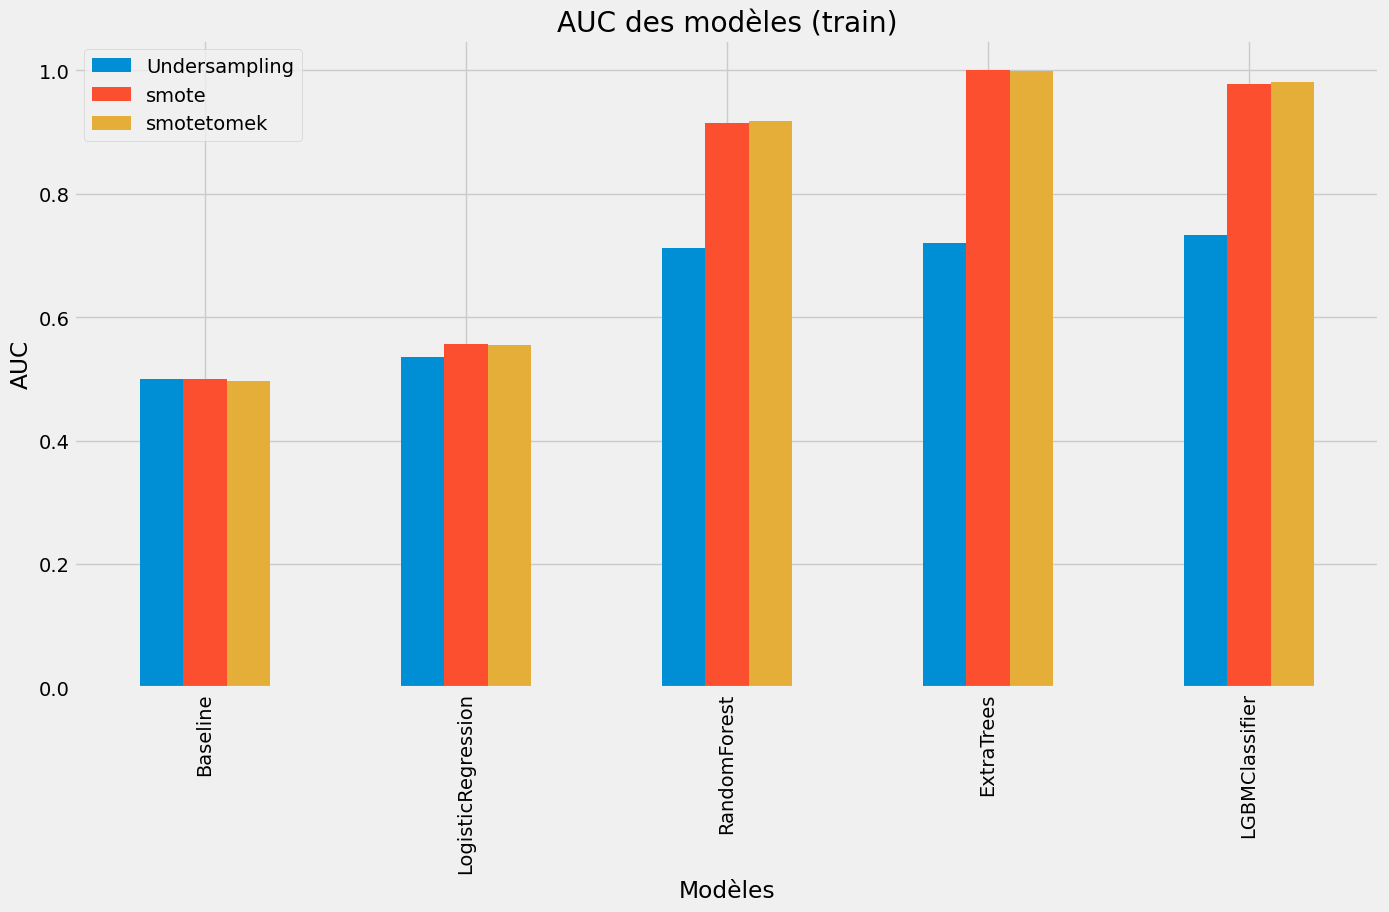

In [229]:
plotdata = pd.DataFrame({
    "Undersampling":results.loc[results['Balancing_method']=='Undersampling']['AUC'].to_list(),
    "smote":results.loc[results['Balancing_method']=='smote']['AUC'].to_list(),
    "smotetomek":results.loc[results['Balancing_method']=='smotetomek']['AUC'].to_list()},
index=["Baseline", "LogisticRegression", "RandomForest","ExtraTrees","LGBMClassifier"])
plotdata.plot(kind="bar",figsize=(15, 8))
plt.title("AUC des modèles (train)")
plt.xlabel("Modèles")
plt.ylabel("AUC")

In [230]:
results.loc[results['Balancing_method']=="smote"]['Time'].to_list()

[0.001255035400390625,
 87.84584188461304,
 24.779825925827026,
 166.67326521873474,
 164.11045575141907]

In [231]:
results.loc[results['Balancing_method']=="smotetomek"]['Time'].to_list()

[0.0017559528350830078,
 310.85560297966003,
 245.41426610946655,
 396.4918808937073,
 399.7763760089874]

Text(0, 0.5, 'Time')

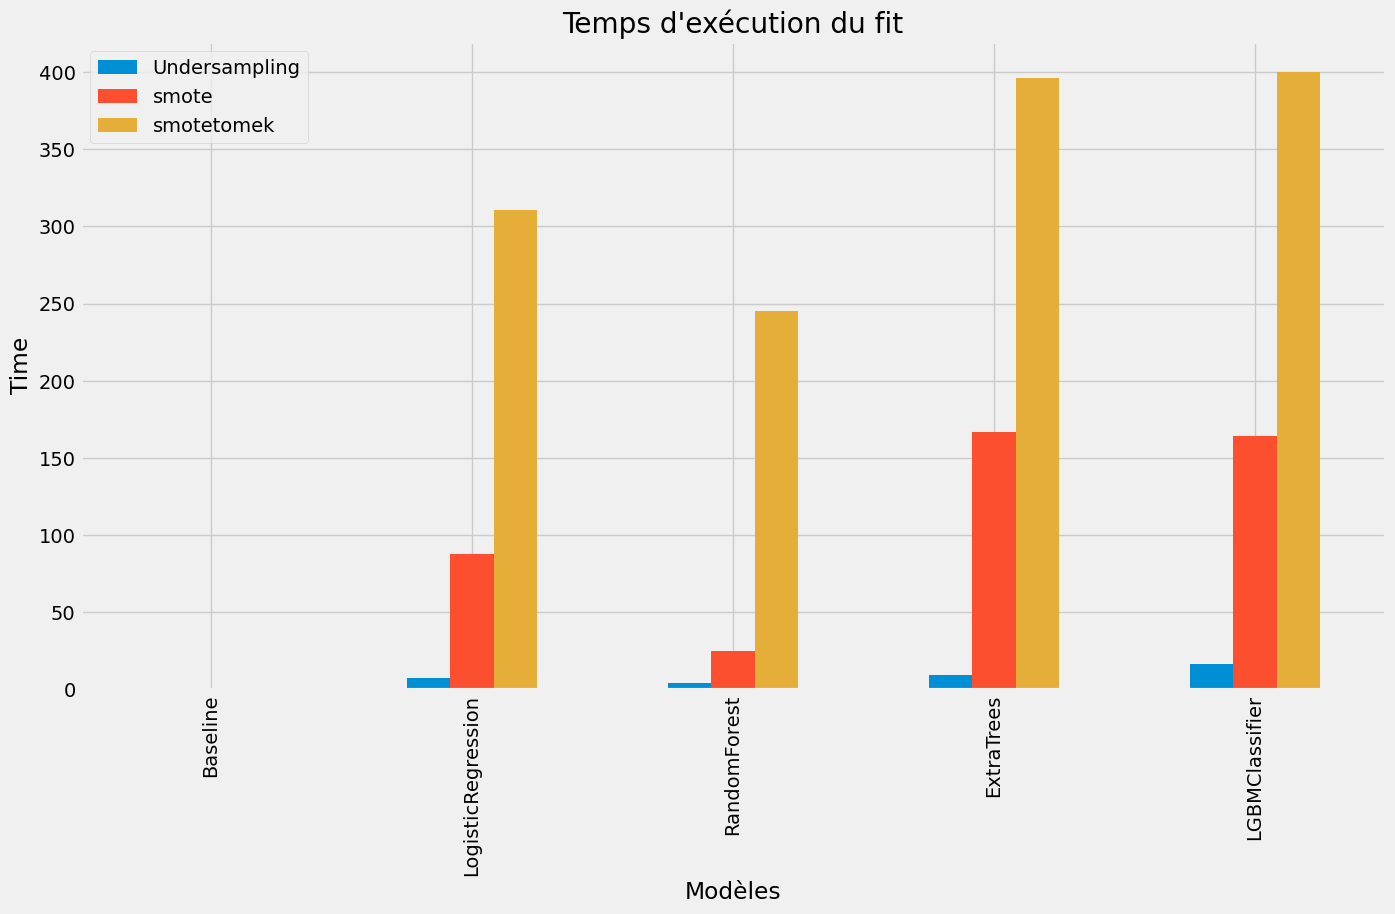

In [232]:
time_models = pd.DataFrame({

    "Undersampling":results.loc[results['Balancing_method']=='Undersampling']['Time'].to_list(),

    "smote":results.loc[results['Balancing_method']=="smote"]['Time'].to_list(),

    "smotetomek":results.loc[results['Balancing_method']=="smotetomek"]['Time'].to_list()},
index=["Baseline", "LogisticRegression", "RandomForest","ExtraTrees","LGBMClassifier"])

time_models.plot(kind="bar",figsize=(15, 8))

plt.title("Temps d'exécution du fit")
plt.xlabel("Modèles")
plt.ylabel("Time")


### <b>Conclusion sur le modeling:<b>

On remarque que l'algorithme Light Gradient Boosting Machine muni de la stratégie de rééquilibrage  "smotetomek" donne les meilleurs résultats sur ce jeu de données. Cepandant, il y a un problème d'installation de la librairie Lightgbm sous Pycharm afin de créer une API et un dashboard pour déployer le modèle de scoring. Pour cela, nous allons utiliser le deuxième meilleur modèle qui est le RandomForest Classifier avec undersampling.

### <b> Fit the train set with Logistic regression : <b>

In [233]:

# Fit with regression logistic - smotetomek
lr_smotetomek.fit(xtrain_smotetomek, ytrain_smotetomek)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(steps=[('sampling', SMOTETomek(random_state=6)),
                ('clf', LogisticRegression())])

In [234]:
#y_proba = hgs_lgbm_os.predict_proba(X_test_imp)
y_proba = lr_smotetomek.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
roc_auc


0.537

### <b> Fit the train set with LGBM Classifier: <b>

In [236]:

# fit du train_set avec LGBMClassifier muni de smotetomek
hgs_lgbm_smotetomek.fit(xtrain_smotetomek, ytrain_smotetomek)

HalvingGridSearchCV(estimator=Pipeline(steps=[('sampling',
                                               SMOTETomek(random_state=6)),
                                              ('clf',
                                               LGBMClassifier(objective='binary',
                                                              random_state=42))]),
                    n_jobs=-1,
                    param_grid={'clf__learning_rate': [0.01, 0.05],
                                'clf__n_estimators': [50, 100, 200]},
                    random_state=0, scoring='roc_auc')

In [237]:

#y_proba = hgs_lgbm_os.predict_proba(X_test_imp)
y_proba = hgs_lgbm_smotetomek.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
roc_auc


0.758

### <b> Fit the train set with ExtraTrees Classifier: <b>

In [239]:
#fit du train_set avec ExtraTrees Classifier muni de smote
hgs_etc_os.fit(xtrain_smotetomek, ytrain_smotetomek)

HalvingGridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                              ('clf', ExtraTreesClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__max_features': [2, 3, 4],
                                'clf__n_estimators': [200, 400]},
                    random_state=0, scoring='roc_auc')

In [240]:
y_proba = hgs_etc_os.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
roc_auc


0.695

### <b> Fit the train set with RandomForest Classifier: <b>

### <b> Undersampling :<b>

In [245]:
# Fit with RandomForest - UNDERSAMPLING

hgs_rf_us.fit(xtrain_us, ytrain_us)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

HalvingGridSearchCV(estimator=RandomForestClassifier(bootstrap=False,
                                                     max_depth=8,
                                                     max_features='auto',
                                                     n_estimators=150),
                    n_jobs=-1,
                    param_grid={'max_features': ['auto'],
                                'n_estimators': [150]},
                    random_state=0, scoring='roc_auc')

In [246]:

y_proba = hgs_rf_us.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
roc_auc


0.737

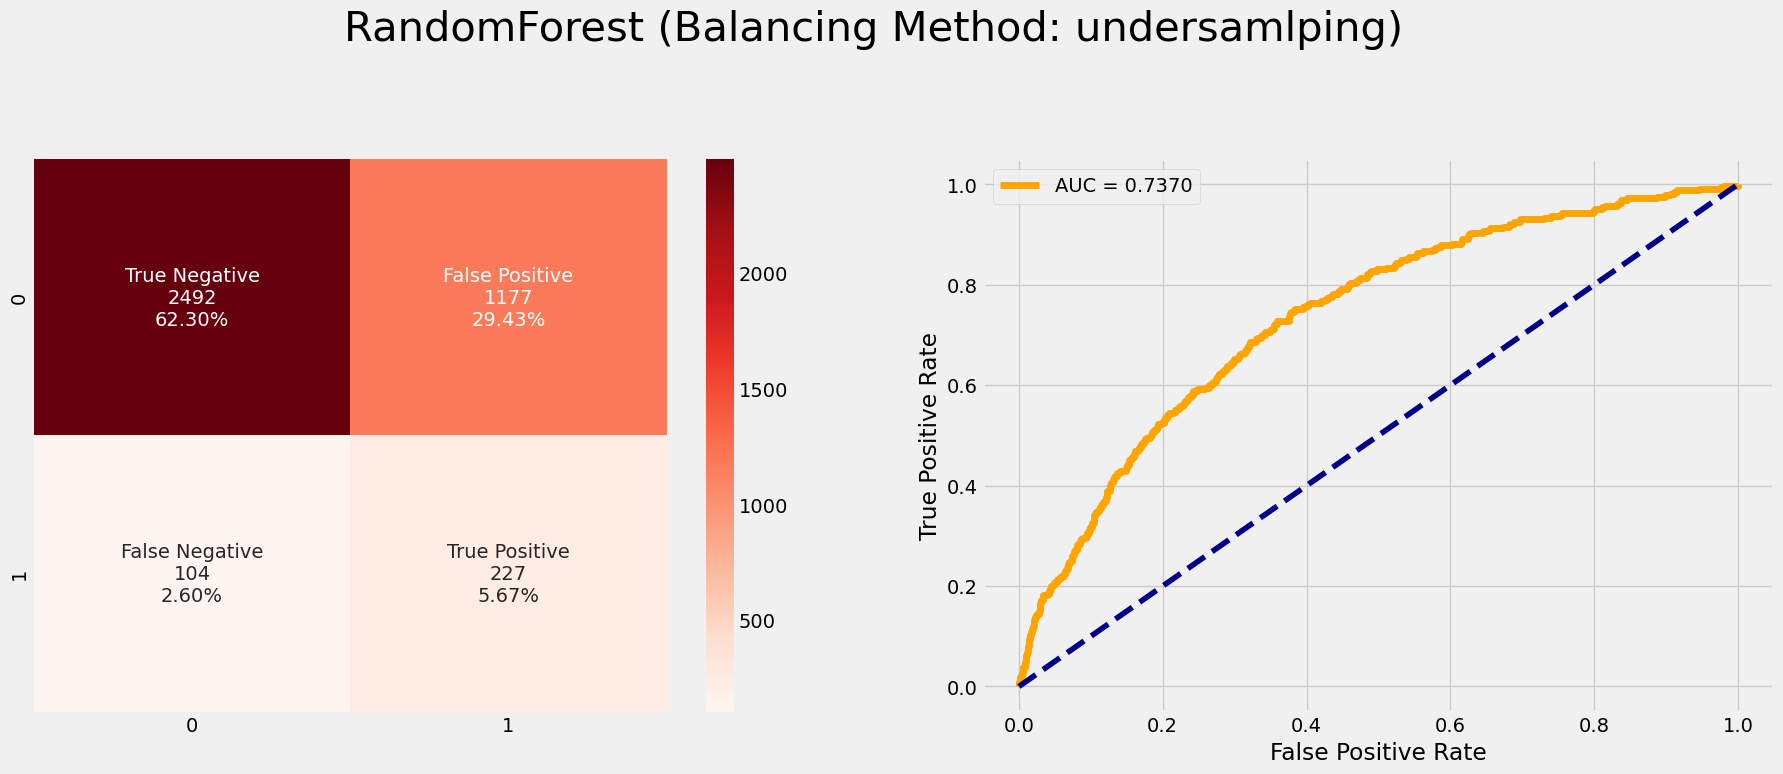

In [248]:
cf_matrix_roc_auc(hgs_rf_us, y_test, hgs_rf_us.predict(xtest), hgs_rf_us.predict_proba(xtest)[:,1], roc_auc, "RandomForest (Balancing Method: undersamlping)")

In [251]:
y_pred = hgs_rf_us.predict(xtest)

In [253]:
y_pred=pd.DataFrame(y_pred)
y_pred

0
0     1.0
1     1.0
2     0.0
3     0.0
4     0.0
...   ...
3995  0.0
3996  0.0
3997  0.0
3998  0.0
3999  1.0

[4000 rows x 1 columns]

In [255]:
y_pred_prob = hgs_rf_us.predict_proba(xtest)[:,1]


In [256]:
y_pred_prob=pd.DataFrame(y_pred_prob)
y_pred_prob

0
0     0.516875
1     0.598253
2     0.339611
3     0.377372
4     0.311662
...        ...
3995  0.395286
3996  0.358912
3997  0.393724
3998  0.435285
3999  0.545637

[4000 rows x 1 columns]

<AxesSubplot:ylabel='Frequency'>

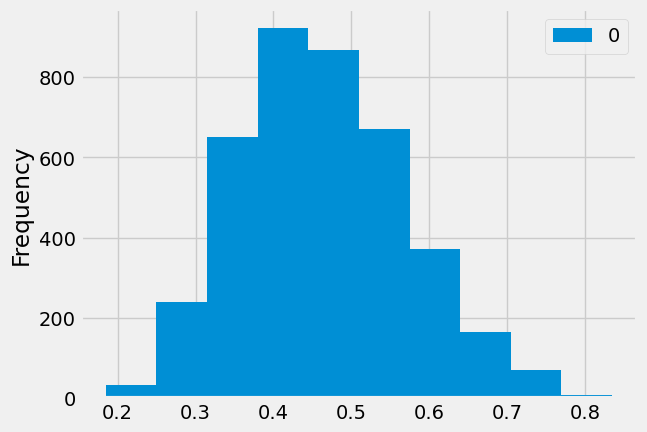

In [261]:
y_pred_prob.plot(kind='hist')

In [263]:
# Plot distribution 
def plot_distribution(df,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of Random Forest with undersampling")
    sns.distplot(df.dropna(),color=color, kde=True,bins=100)
    plt.show()   



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



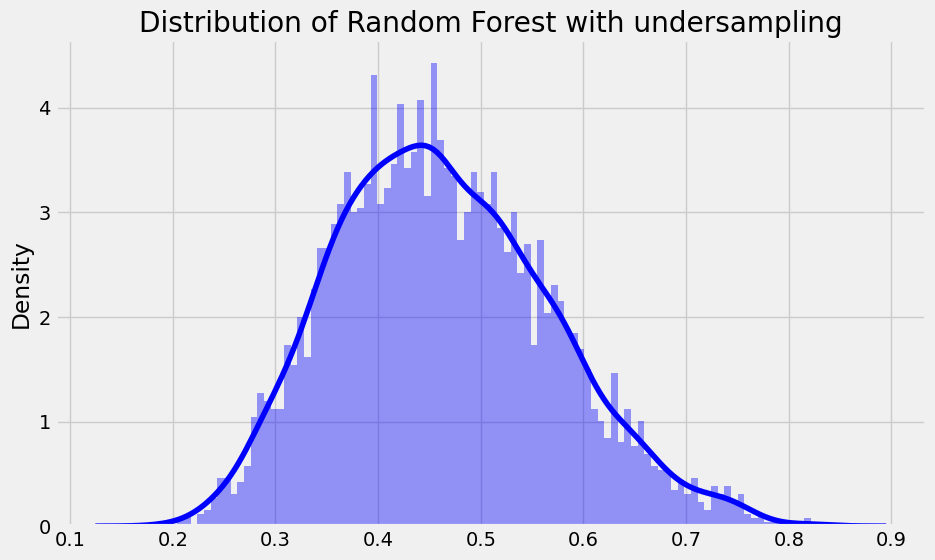

In [264]:
plot_distribution(y_pred_prob, "blue")

### <b>  SMOTE :<b>

In [267]:
# Fit with RandomForest - SMOTE
hgs_rf_os.fit(xtrain_os, ytrain_os)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

HalvingGridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                              ('clf',
                                               RandomForestClassifier(max_features='auto',
                                                                      n_estimators=150,
                                                                      n_jobs=-1,
                                                                      oob_score=True))]),
                    n_jobs=-1,
                    param_grid={'clf__max_depth': [1],
                                'clf__n_estimators': [150, 300]},
                    random_state=0, scoring='roc_auc')

In [268]:

y_proba = hgs_rf_os.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
roc_auc

0.667

### <b>  SMOTETomek :<b>

In [270]:
# Fit with RandomForest - SMOTETOMEK 
hgs_rf_smotetomek.fit(xtrain_smotetomek, ytrain_smotetomek)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

HalvingGridSearchCV(estimator=Pipeline(steps=[('sampling',
                                               SMOTETomek(random_state=6)),
                                              ('clf',
                                               RandomForestClassifier(max_features='auto',
                                                                      n_estimators=150,
                                                                      n_jobs=-1,
                                                                      oob_score=True))]),
                    n_jobs=-1,
                    param_grid={'clf__max_depth': [1],
                                'clf__n_estimators': [150, 300]},
                    random_state=0, scoring='roc_auc')

In [271]:
#y_proba = hgs_rf_us.predict_proba(X_test_imp)
y_proba = hgs_rf_smotetomek.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
roc_auc


0.668

In [273]:
# Best model
best_model=hgs_rf_us

In [274]:

probability = best_model.predict_proba(xtest)
proba_default_payment = probability[:, 1]
proba_default_payment


array([0.51687452, 0.59825277, 0.33961082, ..., 0.39372377, 0.43528467,
       0.54563663])

In [275]:

prediction = best_model.predict(xtest)
prediction


array([1., 1., 0., ..., 0., 0., 1.])

In [276]:
from termcolor import colored

accuracy = accuracy_score(y_test, prediction)
print(colored('L\'accuracy score est de {} .\n \n '.format(
        accuracy), 'blue'))

L'accuracy score est de 0.67975 .
 
 


In [277]:
precision = precision_score(y_test, prediction, average='binary')
print(colored('Le score de précision est de {}.\n \n '.format(
        precision), 'blue'))

Le score de précision est de 0.16168091168091167.
 
 


In [278]:
recall = recall_score(y_test, prediction, average='binary')
print(colored('Le score recall est de {}.\n \n '.format(
        recall), 'blue'))

Le score recall est de 0.6858006042296072.
 
 


In [279]:
f1 = f1_score(y_test, prediction, average='binary')
print(colored('Le score f1 est de {}.\n \n '.format(
        f1), 'blue'))

Le score f1 est de 0.261671469740634.
 
 


In [280]:
roc_auc = roc_auc_score(y_test, proba_default_payment) 
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.7374
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      3669
         1.0       0.16      0.69      0.26       331

    accuracy                           0.68      4000
   macro avg       0.56      0.68      0.53      4000
weighted avg       0.89      0.68      0.75      4000



## Fonction coût métier :<b>

Le but de la banque est d'identifier les personnes qui ne peuvent pas rembourser un prêt. Le défaut de remboursement est donc considéré comme évènement positif, c-à-d posifit = 1.

Les différentes situtaions possibles sont:
    
- TP (True Positives) : lorsque la prédiction est positive, et la valeur réelle est positive. (Le prêt n'est pas accordé et le client ne peut pas rembourser le prêt) 
- TN (True Negatives) : lorsque la prédiction est négative, et la valeur réelle est négative. (Le prêt est pas accordé et le client peut rembourser le prêt) 
- FP (False Positives) :lorsque la prédiction est positive, et la valeur réelle est négative. (Le prêt n'est pas accordé mais le client peut rembourser le prêt)   
- FN (False Negatives) :lorsque la prédiction est negative, et la valeur réelle est positive. (Le prêt est pas accordé mais le client ne peut pas rembourser le prêt)                                                                                                                                                                       

Comme une société de crédit chercher toujours à maximiser ses gains, il faut définir une métrique pertinente pour traiter cette problématique en prenant en considération les points suivants:

- Accorder un crédit à une personne ne pouvant pas le rembourser par la suite (FN) est une perte
- Accorder un crédit à une personne qui le rembousera par la suite (TN) est un gain.
- Refuser le prêt et que le client ne peut pas rembourser (TP) n'est ni une perte, ni un gain.
- Refuser le prêt mais que le client pouvait rembourser (FP) est une perte de client donc d'argent.

En effet, un faux négatif est beaucoup plus coûteux qu'un faux positif.

La fonction métier suivante permet d'attribuer plus de poids à la minimisation des FN.

In [281]:
'''
        Cost function to minimize the risk of reimbursement
    
        Parameters
        --------
        - y_true : pandas dataframe
                   The true values of the target
        - y_pred : pandas dataframe
                   The predicted values for the target
            
        Returns
        --------
        - score : float
                  The score for the prediction
    '''

    #(TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    
    # Setting the bank's gain and loss for each case
   #FN_value   # The loan is granted but the customer defaults : the bank loses money (Type-II Error)
   #FP_value     # The loan is reimbursed : the bank makes money
   #TP_value    # Loan is refused by mistake : the bank loses money it could have made, 
                    #but does not actually lose any money (Type-I Error)
   #TN_value    # The loan is (rightly) refused : the bank neither wins nor loses money
    

def client_score(y_true, y_pred, FN_value=-10, FP_value=-1, TP_value=0, TN_value=1):
    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true,y_pred)
    
    TN = mat_conf[0, 0]
    FN = mat_conf[1, 0]
    FP = mat_conf[0, 1]
    TP = mat_conf[1, 1]
    
    
    Gain_total = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    G_max = (FP + TN)*TN_value + (FN + TP)*TP_value
    G_min = (FP + TN)*FP_value + (FN + TP)*FN_value
    
    score = (Gain_total - G_min)/(G_max - G_min)
    
    return score  

### <b> Optimisation des hyperparamètres du modèle via HyperOpt : <b>

Nous effectuons une nouvelle recherche des hyper-paramètres via HyperOpt basée sur la fonction métier ci-dessus, de manière à minimiser la perte de l'entreprise.

In [282]:
#Create Hyperparameter space
space = {'n_estimators': hp.choice('n_estimators', range(20,200)),
         'max_features': hp.choice('max_features', range(1,20)),
         'max_depth': hp.choice('max_depth', range(1,10)),
         'criterion': hp.choice('criterion', ["gini", "entropy"]),
        }

In [283]:
# define objective function

def objective(params, eval_metric='client_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_features': int(params[ 'max_features']),
        'max_depth': int(params['max_depth'])
        }
    
    model= RandomForestClassifier(**params)   
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, xtrain, y_train, scoring='roc_auc', cv=cv).mean()
    elif eval_metric == 'client_score':   
        y_pred = cross_val_predict(model, xtrain, y_train, method='predict', cv=cv)
        score = client_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [284]:
%%time
best = fmin(fn=objective, space=space, max_evals=20, algo=tpe.suggest)
print("Best: {}".format(best))

100%|████████| 20/20 [01:22<00:00,  4.11s/trial, best loss: 0.31103286384976525]
Best: {'criterion': 0, 'max_depth': 1, 'max_features': 0, 'n_estimators': 9}
CPU times: user 1min 21s, sys: 313 ms, total: 1min 21s
Wall time: 1min 22s


In [285]:

#Fit a new model based on the best parameters
#%%time

best_optim=RandomForestClassifier(n_estimators=160, max_depth = 4, max_features='sqrt')
best_optim.fit(xtrain_us, ytrain_us)

RandomForestClassifier(max_depth=4, n_estimators=160)

In [287]:

roc_auc = roc_auc_score(y_test, best_optim.predict_proba(xtest)[:,1])
print('AUC : %0.6f' %roc_auc)



AUC : 0.737529


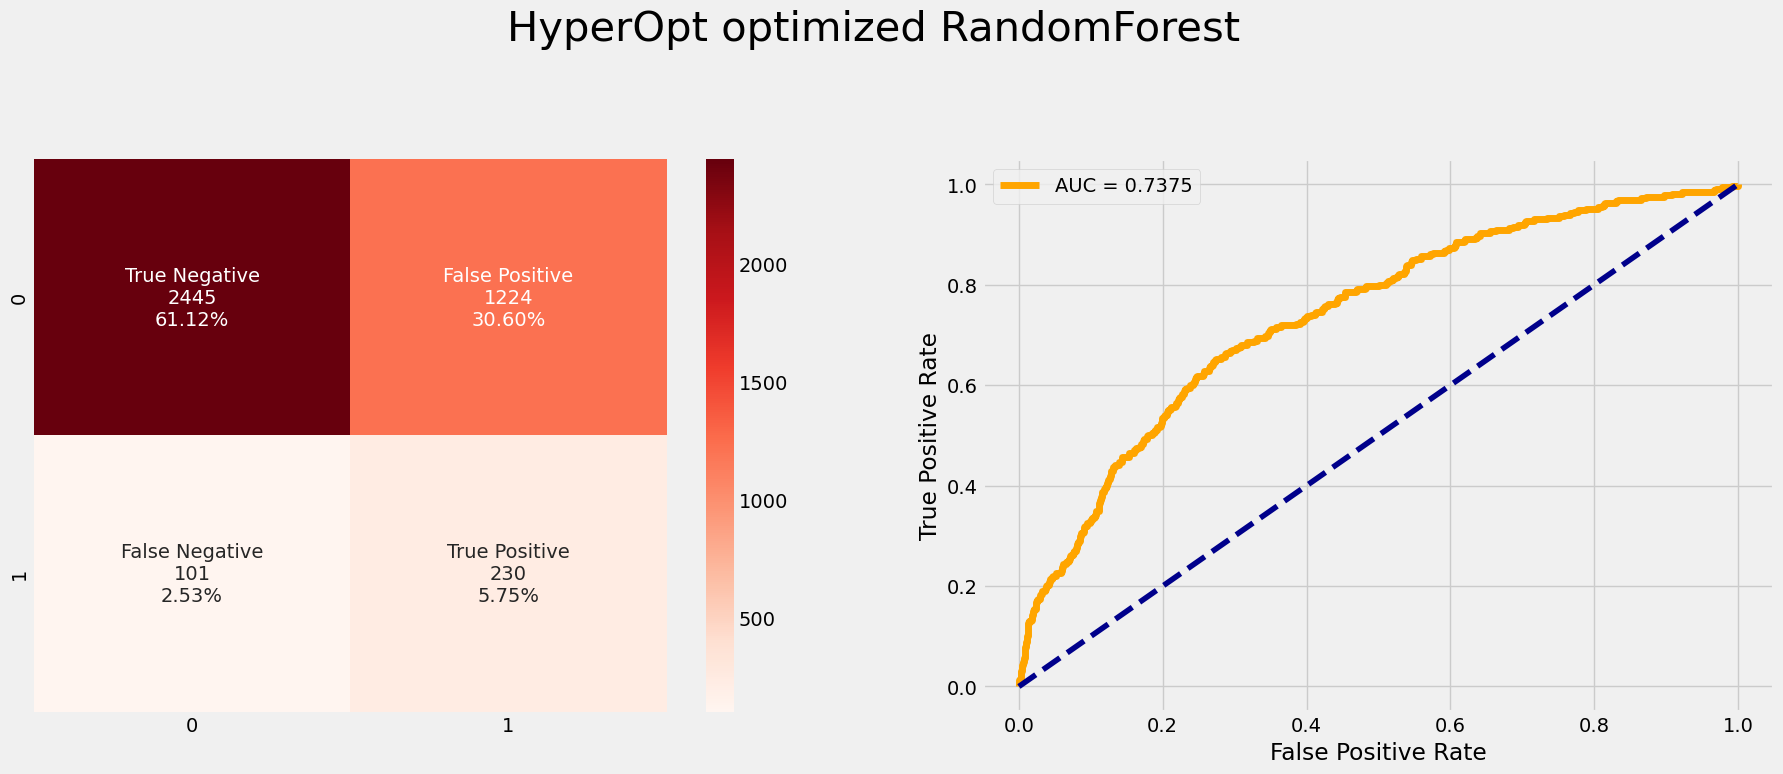

In [288]:

cf_matrix_roc_auc(best_optim, y_test, best_optim.predict(xtest), best_optim.predict_proba(xtest)[:,1]  ,roc_auc, "HyperOpt optimized RandomForest")


In [289]:
best_optim

RandomForestClassifier(max_depth=4, n_estimators=160)

In [290]:
# Features importance of RandomForestClassifier

n = 10    # choose top n features
features_imp = pd.Series(best_optim.feature_importances_, index=xtrain.columns).nlargest(n)

features_imp.sort_values(ascending=False)
print (features_imp.head(10))

EXT_SOURCE_3                        0.057396
EXT_SOURCE_2                        0.052418
DAYS_EMPLOYED                       0.025526
DAYS_BIRTH                          0.022841
EXT_SOURCE_1                        0.021449
BURO_DAYS_CREDIT_MEAN               0.017436
DAYS_EMPLOYED_PERC                  0.017373
BURO_DAYS_CREDIT_UPDATE_MEAN        0.015339
PREV_CODE_REJECT_REASON_XAP_MEAN    0.014438
REFUSED_APP_CREDIT_PERC_MIN         0.014308
dtype: float64


['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'BURO_DAYS_CREDIT_MEAN', 'DAYS_EMPLOYED_PERC', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 'REFUSED_APP_CREDIT_PERC_MIN']


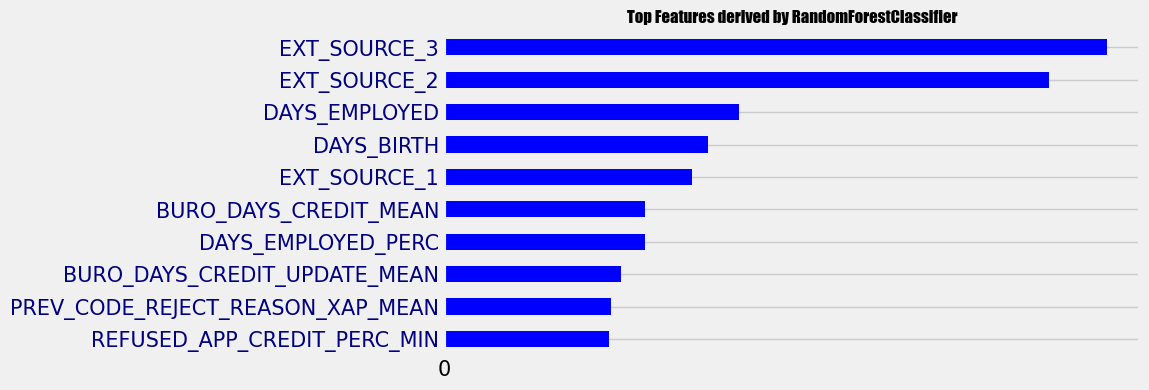

In [291]:
n = 10    # choose top n features

(pd.Series(best_optim.feature_importances_, index=xtrain.columns)
    .nlargest(n)
    .plot(kind='barh', figsize=[8, n/2.5],color='blue')
    .invert_yaxis())    # most important feature is on top, ie, descending order

ticks_x = np.linspace(0, 0., 1)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=15, color='black')
plt.yticks(size=15, color='navy' )
plt.title('Top Features derived by RandomForestClassifier', family='fantasy', size=12)
print(list((pd.Series(best_optim.feature_importances_, index=xtrain.columns).nlargest(n)).index))

### <b> Conclusion sur l'optimisation métier :<b>

- Notre modèle RandomForest sélectionné est optimisé d'un point de vue métier avec HyperOpt.
- On obtient un score AUC amélioré et une baisse du nombre de FN sur le jeu de test.

### <b> Seuil de probabilité optimal pour la fonction coût :<b>

In [292]:
def predict_threshold(model, X, seuil):
    probability = model.predict_proba(X)
    mask = (probability[:, 1] > seuil)
    return mask.astype(int)

int_seuil = np.arange(0.0, 1.01, 0.01)
scores = []
for seuil in int_seuil:
    y_pred_opt = predict_threshold(best_optim, xtest, seuil=seuil)
    score = client_score(y_test, y_pred_opt, FN_value=-10, FP_value=-1, TP_value=0, TN_value=1)
    scores.append(score)


    

Score max du gain: 0.7308414725770098
Seuil optimal: 0.55


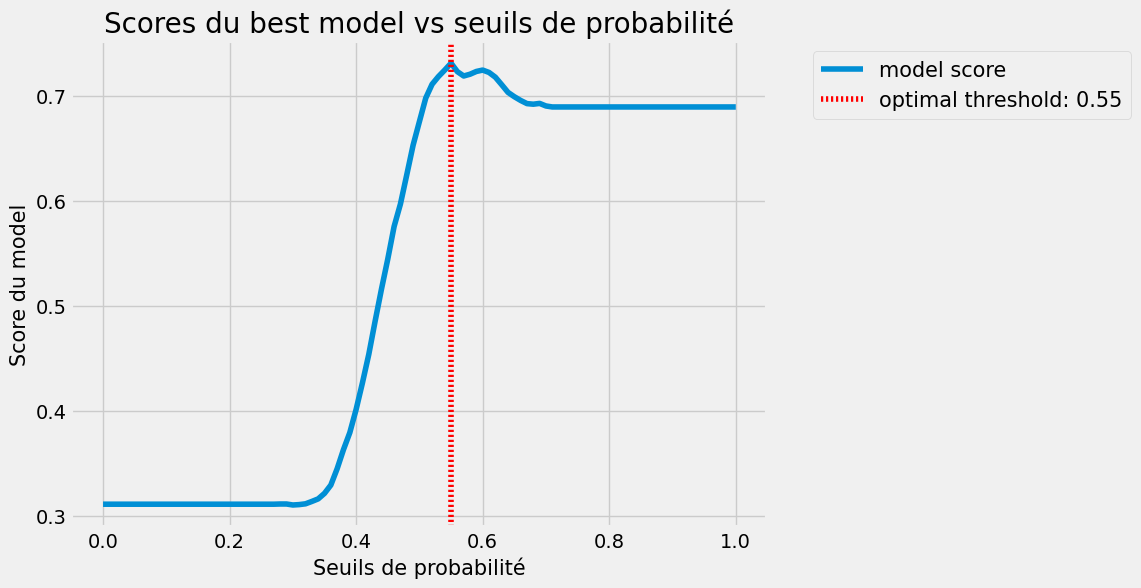

In [293]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(np.arange(0.0, 1.01, 0.01), scores, label="model score")

max_score = max(scores)
opt_threshold = np.arange(0.0, 1.01, 0.01)[scores.index(max_score)]

plt.axvline(x=opt_threshold, color='r', dashes=(0.4, 0.5), label="optimal threshold: {}".format(opt_threshold))

plt.title("Scores du best model vs seuils de probabilité", fontsize=20)
plt.xlabel("Seuils de probabilité", fontsize=15)
plt.ylabel("Score du model", fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)

print("Score max du gain:", max_score)
print("Seuil optimal:", opt_threshold)

In [294]:

y_pred_O = predict_threshold(best_optim, xtest, seuil=opt_threshold)

score = client_score(y_test, y_pred_O, FN_value=-10, FP_value=-1, TP_value=0, TN_value=1)
print("Score du gain :", score)
print("Seuil:", opt_threshold)
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_O))

Score du gain : 0.7308414725770098
Seuil: 0.55
Matrice de confusion :
 [[3206  463]
 [ 194  137]]


In [298]:

y_pred_dum = predict_threshold(best_optim, xtest, seuil=0.5)
score = client_score(y_test, y_pred_dum, FN_value=-10, FP_value=-1, TP_value=0, TN_value=1)
print("Score du gain :", score)
print("Seuil:", 0.5)
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_dum))

Score du gain : 0.675244177310293
Seuil: 0.5
Matrice de confusion :
 [[2445 1224]
 [ 101  230]]


### <b> Interprétabilité: <b>

La librairie SHAP permet de calculer les features importances locale et globale afin de connaitre les principales features qui contribuent à l'élaboration du modèle.

In [300]:
xtrain.shape

(16000, 795)

In [301]:
xtest.shape

(4000, 795)

In [303]:
X_test.shape

(4000, 795)

In [304]:
best_optim

RandomForestClassifier(max_depth=4, n_estimators=160)

In [305]:

# Explaining model predictions using shap library
# Defining Explainer and calculating shape values
%time 
X_importance = xtest
explainer = shap.TreeExplainer(best_optim,xtrain)
shap_values = explainer.shap_values(X_importance, check_additivity=False)





CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


 98%|===================| 7835/8000 [00:24<00:00]        

In [306]:
shap_values 

[array([[-0.00441432,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00313679,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00411716,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.00173279,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00157046,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00304339,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.00441432,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00313679,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00411716,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00173279,  0.        ,  0.        , ...,  

In [307]:
shap_values[0]

array([[-0.00441432,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00313679,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00411716,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00173279,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00157046,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00304339,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [308]:
shap_values[0][0]

array([-4.41431840e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.51789142e-04, -1.78571441e-05,  4.27655462e-04, -2.85658049e-04,
        1.02737320e-04, -9.23214325e-03, -1.05107202e-02, -5.40376603e-05,
       -2.93988317e-04, -3.20562215e-04,  0.00000000e+00, -1.09603423e-03,
       -2.19073373e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.61183216e-06, -1.45562785e-05, -4.58430528e-06,
        0.00000000e+00,  0.00000000e+00, -1.96022727e-05, -8.05450833e-04,
       -1.46920187e-05,  0.00000000e+00, -2.14879106e-03, -1.17405752e-02,
       -2.97218890e-02, -2.43740080e-04, -9.03744185e-04, -1.89321293e-04,
       -1.62828623e-04, -2.66958058e-04, -2.07842506e-04,  0.00000000e+00,
       -1.14269383e-04,  0.00000000e+00, -2.32329406e-05,  0.00000000e+00,
       -2.23421009e-04,  2.17970496e-05, -4.49315466e-04,  2.14964349e-05,
        3.53662402e-05, -3.25678025e-04, -1.07132557e-04,  0.00000000e+00,
        1.21724504e-05,  

In [309]:
explainer

In [310]:
explainer.expected_value

array([0.52941514, 0.47058486])

#### <b>Interprétabilité locale:<b> 

In [311]:
shap.initjs() # initialize the JavaScript visualization in notebook environment


In [312]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0],feature_names=columns)

In [313]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1],feature_names=columns)

In [314]:
shap.force_plot(explainer.expected_value[1], shap_values[0][0],feature_names=columns)

In [315]:
shap.force_plot(explainer.expected_value[1], shap_values[0][1],feature_names=columns)

#### <b>Interprétabilité globale:<b> 

In [316]:
print(columns)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_NAME_CONTRACT_STATUS_SIGNED_MAX',
       'CC_NAME_CONTRACT_STATUS_SIGNED_MEAN',
       'CC_NAME_CONTRACT_STATUS_SIGNED_SUM',
       'CC_NAME_CONTRACT_STATUS_SIGNED_VAR', 'CC_NAME_CONTRACT_STATUS_NAN_MIN',
       'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_NAN_SUM', 'CC_NAME_CONTRACT_STATUS_NAN_VAR',
       'CC_COUNT'],
      dtype='object', length=795)


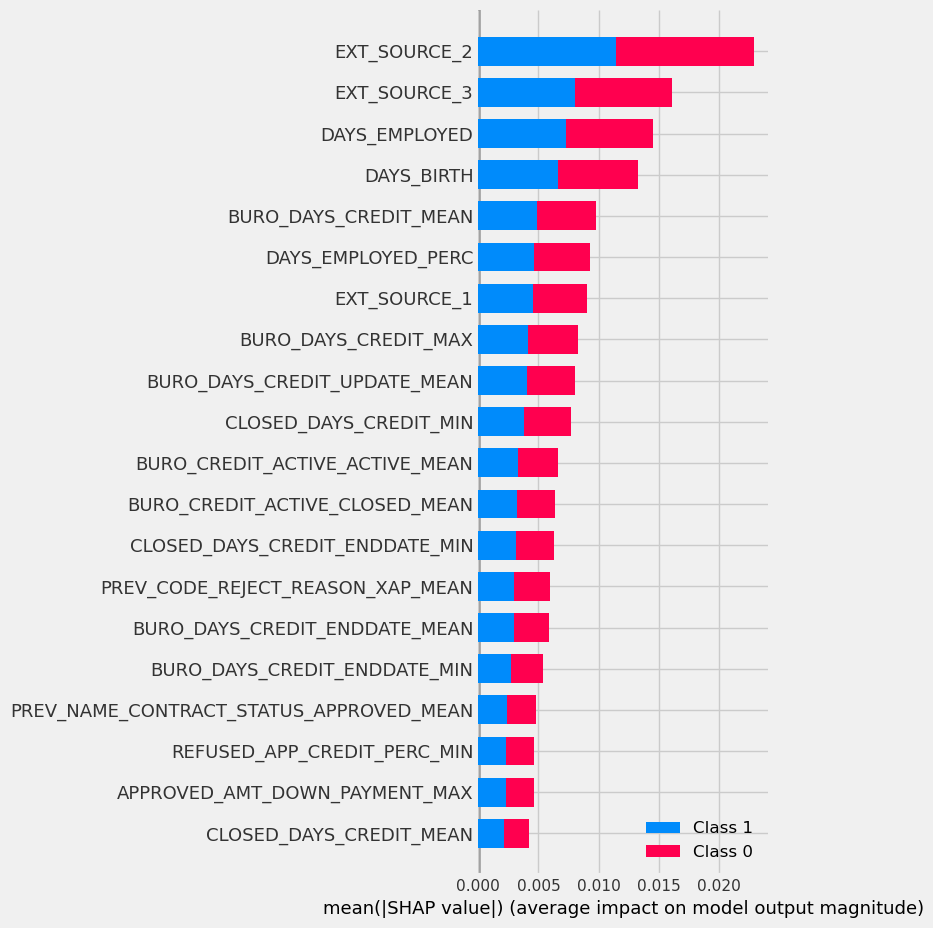

In [317]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance,feature_names=columns)

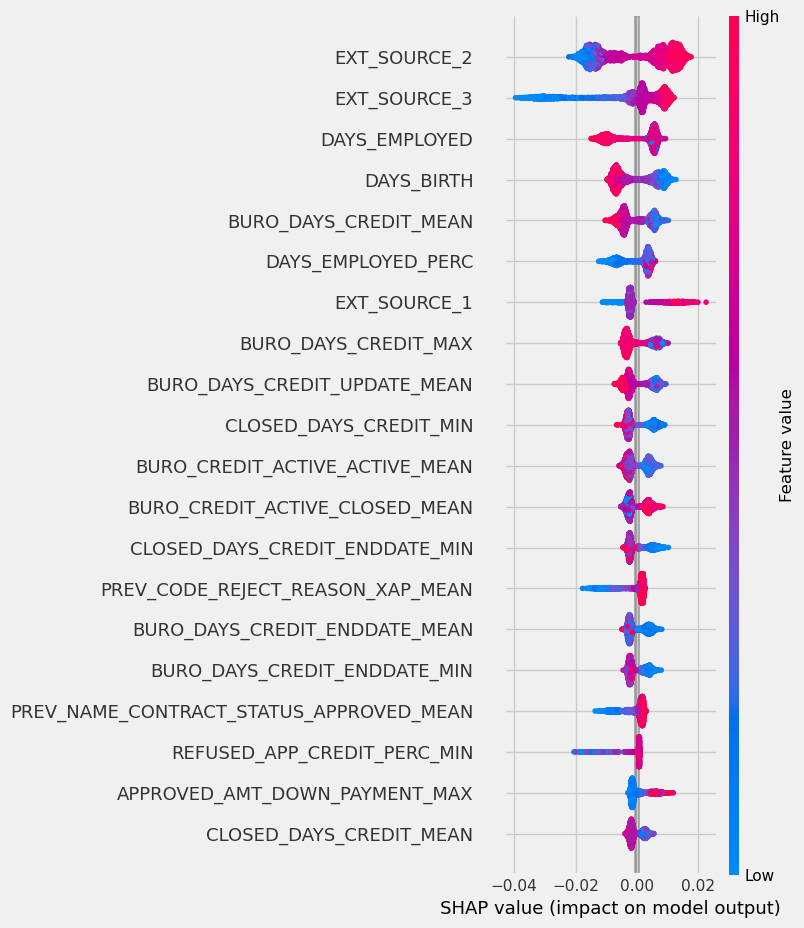

In [318]:
shap.summary_plot(shap_values[0],
                  features=X_importance,
                  feature_names=columns)


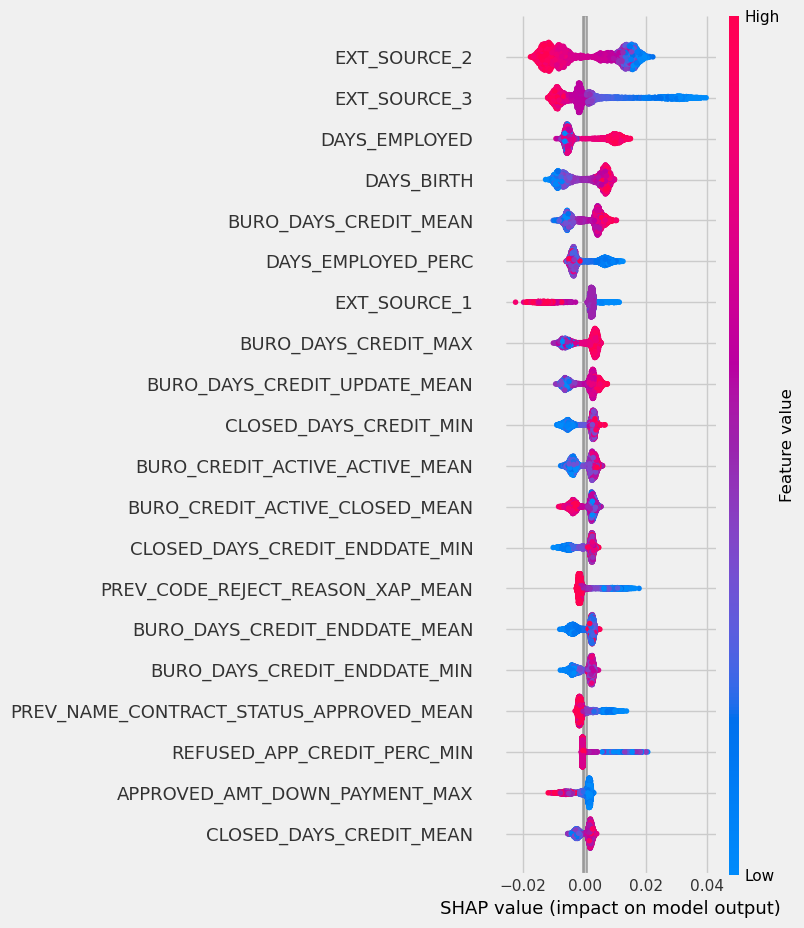

In [319]:
shap.summary_plot(shap_values[1],
                  features=X_importance,
                  feature_names=columns)


In [320]:
shap_values[0][0]

array([-4.41431840e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.51789142e-04, -1.78571441e-05,  4.27655462e-04, -2.85658049e-04,
        1.02737320e-04, -9.23214325e-03, -1.05107202e-02, -5.40376603e-05,
       -2.93988317e-04, -3.20562215e-04,  0.00000000e+00, -1.09603423e-03,
       -2.19073373e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.61183216e-06, -1.45562785e-05, -4.58430528e-06,
        0.00000000e+00,  0.00000000e+00, -1.96022727e-05, -8.05450833e-04,
       -1.46920187e-05,  0.00000000e+00, -2.14879106e-03, -1.17405752e-02,
       -2.97218890e-02, -2.43740080e-04, -9.03744185e-04, -1.89321293e-04,
       -1.62828623e-04, -2.66958058e-04, -2.07842506e-04,  0.00000000e+00,
       -1.14269383e-04,  0.00000000e+00, -2.32329406e-05,  0.00000000e+00,
       -2.23421009e-04,  2.17970496e-05, -4.49315466e-04,  2.14964349e-05,
        3.53662402e-05, -3.25678025e-04, -1.07132557e-04,  0.00000000e+00,
        1.21724504e-05,  

In [321]:
rf_optim=best_optim

In [322]:
rf_optim

RandomForestClassifier(max_depth=4, n_estimators=160)

### <b>Sauvegarde :<b>

In [323]:
df_test_output['TARGET']=y_test

In [324]:
df_test_output.head(3)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
329363             -2.0           0.0              1.0           1.0   
396164             -2.0           1.0              0.0           0.0   
293880             -2.0           1.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
329363             -1.649985   -0.962708    -1.375983        -1.020410   
396164             -1.650010   -0.962705    -1.375931        -1.020407   
293880             -1.650008   -0.962707    -1.375938        -1.020408   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
329363                        3.000186    2.154324       0.901164   
396164                      -11.436000    2.154180       0.900293   
293880                       17.128973    2.154116       0.900871   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
329363               0.840252         1.283758         -9.0        -1.0   
396164               0.840219         1.283940         -2.0        -1.0   
293880               0.840337         1.283557         -6.0        -1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
329363                -1.0              1.0              -1.0         0.0   
396164                -1.0              1.0              -1.0         1.0   
293880                -2.0              0.0              -1.0         0.0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
329363             0.0             -2.0                  -1.0   
396164             0.0             -2.0                  -2.0   
293880             0.0             -2.0                  -2.0   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
329363                             -1.0                  -3.0625   
396164                             -2.0                  -3.1250   
293880                             -2.0                  -2.8750   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
329363                             0.0                         0.0   
396164                             0.0                         0.0   
293880                             0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
329363                              0.0                     1.0   
396164                              0.0                     0.0   
293880                              0.0                     0.0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
SK_ID_CURR                                                                  
329363                         1.0                      1.0     -0.504478   
396164                         0.0                      0.0     -0.658963   
293880                         0.0                      0.0     -0.504478   

            EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
SK_ID_CURR                                                                 
329363         -5.927626     -8.345796         -0.0876           -0.0765   
396164         -5.817312     -9.319173         -0.0876           -0.0765   
293880         -2.808579     -4.839288         -0.0876           -0.0765   

            YEARS_BEGINEXPLUATATION_AVG  YEARS_BUIL

In [325]:
df_test_output.reset_index(level=0, inplace=True)
df_test_output.head(3)

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      329363         -2.0           0.0              1.0           1.0   
1      396164         -2.0           1.0              0.0           0.0   
2      293880         -2.0           1.0              0.0           0.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0         -1.649985   -0.962708    -1.375983        -1.020410   
1         -1.650010   -0.962705    -1.375931        -1.020407   
2         -1.650008   -0.962707    -1.375938        -1.020408   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    3.000186    2.154324       0.901164           0.840252   
1                  -11.436000    2.154180       0.900293           0.840219   
2                   17.128973    2.154116       0.900871           0.840337   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         1.283758         -9.0        -1.0            -1.0              1.0   
1         1.283940         -2.0        -1.0            -1.0              1.0   
2         1.283557         -6.0        -1.0            -2.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0              -1.0         0.0         0.0             -2.0   
1              -1.0         1.0         0.0             -2.0   
2              -1.0         0.0         0.0             -2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                  -1.0                         -1.0                  -3.0625   
1                  -2.0                         -2.0                  -3.1250   
2                  -2.0                         -2.0                  -2.8750   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     1.0   
1                          0.0                     0.0   
2                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     1.0                      1.0     -0.504478   
1                     0.0                      0.0     -0.658963   
2                     0.0                      0.0     -0.504478   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0     -5.927626     -8.345796         -0.0876           -0.0765   
1     -5.817312     -9.319173         -0.0876           -0.0765   
2     -2.808579     -4.839288         -0.0876           -0.0765   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                      -1964.2           -0.762         -0.0212   
1                      -1964.2           -0.762         -0.0212   
2                      -1964.2           -0.762         -0.0212   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0            0.0        -0.1379        -0.1667        -0.2083       -0.0475   
1            0.0        -0.1379        -0.1667        -0.2083       -0.0475   
2            0.0        -0.1379        -0.1667        -0.2083       -0.0475   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0               -0.0754        -183.625                      0.0   
1               -0.0754        -183.625                      0.0   
2               -0.0754        -183.625                      0.0   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0            -0.0036           -0.084           -0.07455   
1            -0.0036           -0.084           -0.07455   
2            -0.0036           -0.084           -0.07455   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                       -1963.2

In [326]:
# Sauvegarde du dataframe test_df_output après feature engineering pour les prédictions sur le dashbord.

PATH='/Users/asus2/PROJET7/DONNEES/'

df_test_output.to_csv(PATH + "df_test_output.csv", index=False)


In [327]:
#Sauvegarde du modèle
pickle.dump(rf_optim, open("./RandomForestClassifier.pkl", "wb"))

In [329]:

#Sauvegarde des fichiers au format parquet
df_test.to_parquet(PATH+'df_test.parquet')
df_test_output.to_parquet(PATH+"df_test_output.parquet")


In [337]:
df_test_output.head(10)

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      329363         -2.0           0.0              1.0           1.0   
1      396164         -2.0           1.0              0.0           0.0   
2      293880         -2.0           1.0              0.0           0.0   
3      110382         -1.0           0.0              1.0           0.0   
4      130594         -1.0           0.0              0.0           0.0   
5      373483         -2.0           0.0              0.0           0.0   
6      304211         -2.0           0.0              0.0           1.0   
7      301094         -1.0           0.0              0.0           0.0   
8      118763         -2.0           0.0              0.0           1.0   
9      192869         -2.0           0.0              1.0           0.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0         -1.649985   -0.962708    -1.375983        -1.020410   
1         -1.650010   -0.962705    -1.375931        -1.020407   
2         -1.650008   -0.962707    -1.375938        -1.020408   
3         -1.650008   -0.962706    -1.375889        -1.020407   
4         -1.650005   -0.962708    -1.375971        -1.020409   
5         -1.650004   -0.962708    -1.375949        -1.020409   
6         -1.650008   -0.962708    -1.375990        -1.020410   
7         -1.650012   -0.962708    -1.375986        -1.020410   
8         -1.649960   -0.962706    -1.375916        -1.020407   
9         -1.650004   -0.962707    -1.375938        -1.020408   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    3.000186    2.154324       0.901164           0.840252   
1                  -11.436000    2.154180       0.900293           0.840219   
2                   17.128973    2.154116       0.900871           0.840337   
3                   -1.630885    2.154213       0.899669           0.840292   
4                  -27.420663    2.154064       0.900871           0.840288   
5                  -35.479071    2.154183       0.899522           0.840261   
6                  -27.420663    2.154230       0.901178           0.840375   
7                   33.191204    2.154205       0.899355           0.840395   
8                   -2.851856    2.154244       0.901024           0.840368   
9                   38.379612    2.154354       0.901264           0.840104   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         1.283758         -9.0        -1.0            -1.0              1.0   
1         1.283940         -2.0        -1.0            -1.0              1.0   
2         1.283557         -6.0        -1.0            -2.0              0.0   
3         1.283504         -9.0        -1.0            -1.0              1.0   
4         1.283419         -9.0        -1.0            -2.0              0.0   
5         1.283962         -9.0        -1.0            -1.0              1.0   
6         1.283462         -9.0        -1.0            -1.0              0.0   
7         1.284148         -9.0        -1.0            -1.0              1.0   
8         1.283468         -9.0        -1.0            -1.0              0.0   
9         1.283972         -9.0        -1.0            -1.0              1.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0              -1.0         0.0         0.0             -2.0   
1              -1.0         1.0         0.0             -2.0   
2              -1.0         0.0         0.0             -2.0   
3              -1.0         1.0         0.0             -2.0   
4              -1.0         1.0         0.0             -3.0   
5              -1.0         0.0         0.0             -2.0   
6              -1.0         0.0         0.0             -2.0   
7              -1.0         0.0         0.0             -2.0   
8              -1.0         1.0         0.0             -1.0   
9              -1.0         1.0         0.0             -3.0   

   RE

In [338]:
print(os.getcwd())

/Users/asus2/PROJET7
